In [1]:
import numpy as np
import networkx as nx
import seaborn as sns
import csaps

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.stats import gamma, lognorm

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Avenir"
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def approximate(s = 0, mu = 1e-4, amp = 1, lamb = 1, N = 100):

    idx = np.arange(0, N + 1)
    d = (2 + amp * s) * (N - idx) + mu / lamb * idx * (1 + amp * s)
    a = (N - idx) / d
    b = (N - idx) * (1 - mu / lamb) * (1 + amp * s) / d
    c = N * mu / lamb * (1 + amp * s) / d

    alpha = np.zeros(N)
    beta = np.zeros(N)
    alpha[N - 1] = a[N - 1]
    beta[N - 1] = b[N - 1] + c[N - 1]
    for i in idx[1:-2][::-1]:
        beta[i] = (b[i] * beta[i + 1] + c[i]) / (1 - b[i] * alpha[i + 1])
        alpha[i] = a[i] / (1 - b[i] * alpha[i + 1])
        
    return beta[1]


def approximate_t(s = 0, mu = 1e-4, amp = 1, lamb = 1):
    N = 100
    idx = np.arange(1, N) 
    W = (N + idx * s)
    P1 = np.eye(N + 2) 
    P1[idx, idx - 1] = lamb * 1 / W * idx * (1 - idx / N) 
    P1[idx, idx + 1] = lamb * (1 + amp * s) / W * idx * (1 - idx / N) 
    P1[idx, idx] -=  (P1[idx, idx - 1] + P1[idx, idx + 1])
    P1[idx, idx] -= mu * (1 + s) / W * idx  * idx / N 
    P1[idx, idx + 1] -= mu * (1 + s) / W * idx * (1 - idx / N) 
    P1[idx, N + 1] += mu * (1 + s) / W * idx 
    P1[N, N] -= mu
    P1[N, N + 1] += mu 
    
    F = np.linalg.inv(np.eye(N) - P1[1:N + 1, 1:N + 1]) 
    pfix = F @ P1[1:-1, [0,-1]]
    
    return F[0] @ pfix[:,1] / pfix[0,1]

def process(key, N = 100):
    path = ""
    data_bd = np.zeros((1 * N,4))
    raw_bd = np.loadtxt(path + key + '_results_bd.txt')
    
    data_bd[:,0] = raw_bd[:,0]
    data_bd[:,1] = raw_bd[:,1]
    data_bd[:,2] = raw_bd[:,3] / (raw_bd[:,2] + raw_bd[:,3])
    data_bd[:,3] = raw_bd[:,5]
    data_bd[:,3][np.where(data_bd[:,3] == 0)] = np.nan    
    
    data_db = np.zeros((1 * N,4))
    raw_db = np.loadtxt(path + key + '_results_db.txt')

    data_db[:,0] = raw_db[:,0]
    data_db[:,1] = raw_db[:,1]
    data_db[:,2] = raw_db[:,3] / (raw_db[:,2] + raw_db[:,3])
    data_db[:,3] = raw_db[:,5]
    data_db[:,3][np.where(data_db[:,3] == 0)] = np.nan 
    
    #print("done")
    return data_bd, data_db


def process_single(key, N = 100, approx = False):
    path = ""
    data_bd = np.zeros((N,3))
    raw_bd = np.loadtxt(path + key + '_results_bd.txt')

    data_bd[:,0] = raw_bd[:,0]
    data_bd[:,1] = raw_bd[:,2] / (raw_bd[:,1] + raw_bd[:,2])
    data_bd[:,2] = raw_bd[:,4] #/ raw_bd[:,2]
    data_bd[:,2][np.where(data_bd[:,2] == 0)] = np.nan    
    data_db = np.zeros((N,3))
    raw_db = np.loadtxt(path + key + '_results_db.txt')

    data_db[:,0] = raw_db[:,0]
    data_db[:,1] = raw_db[:,2] / (raw_db[:,1] + raw_db[:,2])
    data_db[:,2] = raw_db[:,4] #/ raw_db[:,2]
    data_db[:,2][np.where(data_db[:,2] == 0)] = np.nan 
    
    #print("done")
    return data_bd, data_db


def single(s, N = 100, amp = 1):
    return (1 - (1+s)**(-amp)) / (1 - (1+s)**(-N*amp))

def color_line(x, y, value, axs):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)


    norm = plt.Normalize(0, 1)
    lc = LineCollection(segments, cmap='RdYlBu', norm=norm)
    lc.set_array(value)
    lc.set_linewidth(5)
    line = axs.add_collection(lc)
    
    
def trans(x,y, s = 0.999, pad = 2 * [0.05]):
    idx = np.isnan(y) == False
    x = x[idx]
    y = y[idx]
    
    idx = np.isnan(x) == False
    x = x[idx]
    y = y[idx]
    
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    
    idx = np.unique(x, return_index=True)[1]
    
    x = x[idx]
    y = y[idx]
    sp = csaps.CubicSmoothingSpline(x, y, smooth=s)
    
    xs = np.linspace(x.min() - pad[0], x.max() + pad[1], 100)
    ys = sp(xs)
    return xs,ys

def large(s = 0, mu = 1e-4, amp = 1, lamb = 1,N = 100):
    a_p = ((2 + amp * s) + np.sqrt((2 + amp * s)**2 - 4 * (1 + amp * s) * (1 - mu / lamb))) / (2 * (1 + amp * s) * (1 - mu / lamb))
    a_n = ((2 + amp * s) - np.sqrt((2 + amp * s)**2 - 4 * (1 + amp * s) * (1 - mu / lamb))) / (2 * (1 + amp * s) * (1 - mu / lamb))
    return 1 + (a_n**N * a_p - a_p**N * a_n) / (a_p**N - a_n**N) 

# Figure 2

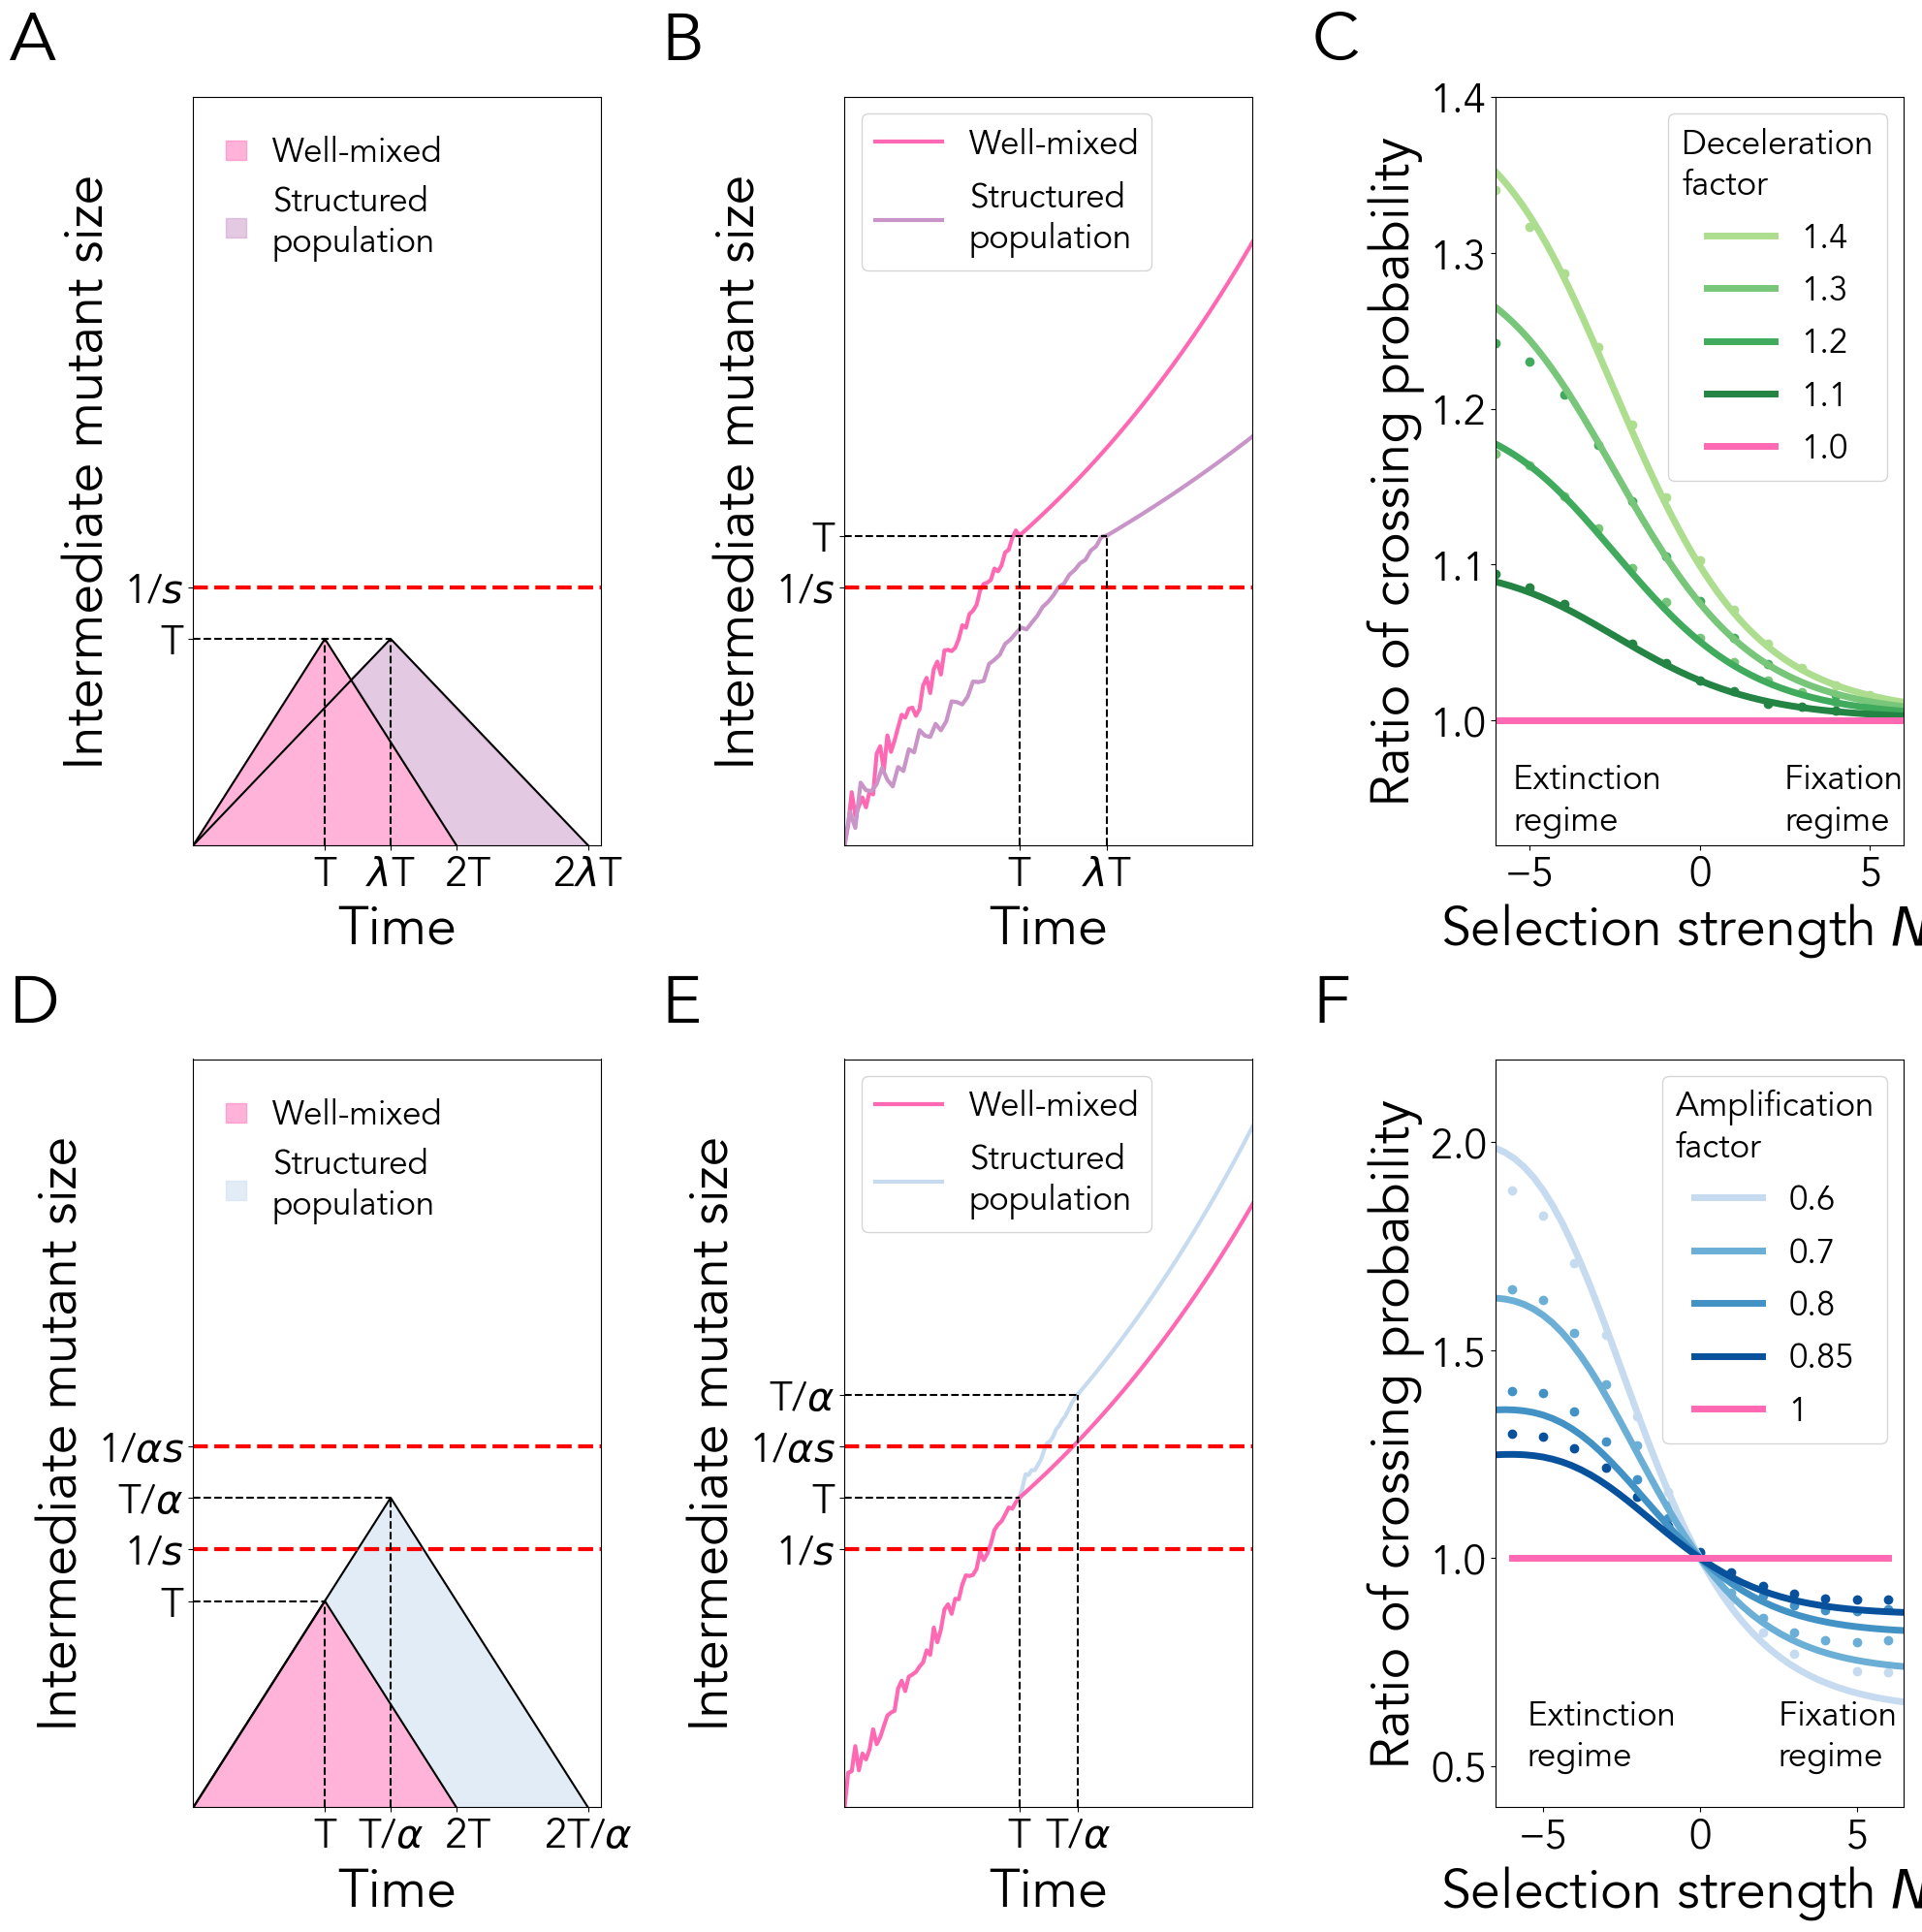

In [ ]:
plt.figure(figsize = (20,20))
ax = plt.subplot(231)
plt.plot([0,1,2],[0,0.8,0], c = 'k')
plt.fill_between([0,1,2],[0,0.8,0], 0, color = '#ff69b4', alpha = 0.5)
plt.fill_between([1.2,1.5,2,3],[0.65, 0.8, 0.525, 0], [0.65,0.4,0,0], 
                 color = '#c994c7', alpha = 0.5)


plt.plot([0,1.5,3],[0,0.8,0], c = 'k')

plt.plot([0,1.5],[0.8, 0.8], linestyle = '--', c = 'k')
plt.plot([0,3.5],[1, 1], linestyle = '--', c = 'r', linewidth = 3)

plt.plot([1,1],[0, 0.8], linestyle = '--', c = 'k')
plt.plot([1.5,1.5],[0, 0.8], linestyle = '--', c = 'k')

plt.xticks([1, 1.5, 2, 3], ['T', '$\lambda$T', '  2T', '2$\lambda$T'], fontsize = 30)
plt.yticks([0.8, 1], ['T', '1/$s$'], fontsize = 30)

plt.fill_between([0.25,0.4], 2.655, 2.73, color = '#ff69b4', alpha = 0.5)
plt.text(0.6, 2.65, 'Well-mixed', c = 'k', fontsize = 25)
plt.fill_between([0.25,0.4], 2.355, 2.43, color = '#c994c7', alpha = 0.5)
plt.text(0.6, 2.3, 'Structured\npopulation', c = 'k', fontsize = 25)


plt.xlim(0, 3.1)
plt.ylim(0, 2.9)

plt.xlabel('Time', fontsize = 40)
plt.ylabel('Intermediate mutant size', fontsize = 40)
plt.text(-0.45, 1.05, 'A', fontsize = 50, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(232)
x = np.linspace(0,1.5,50)
y = np.linspace(0,1.2,50)
y[1:-1] += (0.2 * np.random.rand(50) / np.exp(x))[1:-1]
plt.plot(x, y, c = '#ff69b4', linewidth = 3)

x = np.linspace(0,2.25,50)
y = np.linspace(0,1.2,50)
y[1:-1] += (0.2 * np.random.rand(50) / np.exp(x))[1:-1]
plt.plot(x, y, c = '#c994c7', linewidth = 3)

x = np.linspace(0, np.log(10))
plt.plot(x + 1.5, 1.2 * np.exp(x / 3), c = '#ff69b4', linewidth = 3)

x = np.linspace(0, np.log(10) * 1.5)
plt.plot(x + 2.25, 1.2 * np.exp(x / 1.5 / 3), c = '#c994c7', linewidth = 3)


plt.plot([0,3.5],[1, 1], linestyle = '--', c = 'r', linewidth = 3)

plt.plot([1.5,1.5],[0, 1.2], linestyle = '--', c = 'k')
plt.plot([2.25,2.25],[0, 1.2], linestyle = '--', c = 'k')
plt.plot([0,2.25],[1.2, 1.2], linestyle = '--', c = 'k')

plt.xticks([1.5, 2.25], ['T', '$\lambda$T'], fontsize = 30)
plt.yticks([1,1.2], ['1/$s$', 'T'], fontsize = 30)

plt.xlim(0, 3.5)
plt.ylim(0, 2.9)

plt.xlabel('Time', fontsize = 40)
plt.ylabel('Intermediate mutant size', fontsize = 40)

plt.legend(['Well-mixed', 'Structured\npopulation'], fontsize = 25, loc = 'upper left')

plt.text(-0.45, 1.05, 'B', fontsize = 50, transform=ax.transAxes)
##########################################################################

c = ['#addd8e', '#78c679', '#41ab5d', '#238443']#[::-1]
sns.set_palette(c)
ax = plt.subplot(233)
s = np.linspace(-0.15,0.15, 201)

N = 100
mu = 1e-4
y1 = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1/1.4) for s in s])
y2 = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1/1.3) for s in s])
y3 = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1/1.2) for s in s])
y4 = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1/1.1) for s in s])

z = np.array([approximate(s = s, N = N,mu=mu) for s in s])

plt.plot(N * s, (y1/z), linewidth = 5)
plt.plot(N * s, (y2/z), linewidth = 5)
plt.plot(N * s, (y3/z), linewidth = 5)
plt.plot(N * s, (y4/z), linewidth = 5)

plt.plot([-6,6], 2 * [1], linewidth = 5, c = '#ff69b4')


ls =  np.arange(-0.2,0.21,0.01)
norm = np.array([approximate(s = s, mu = mu, N = N) for s in ls]) 

data_bd, data_db = process('fig2_data/tunnel/reg982', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

data_bd, data_db = process('fig2_data/tunnel/reg1067', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

data_bd, data_db = process('fig2_data/tunnel/reg1014', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

data_bd, data_db = process('fig2_data/tunnel/reg1088', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

plt.xticks([-5, 0, 5], fontsize = 30)
plt.yticks(fontsize = 30)

plt.xlabel('Selection strength $Ns$', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)

plt.xlim(-6,6)
plt.ylim(0.92,1.4)

plt.text(-5.5, 0.93, 'Extinction \nregime', fontsize = 25)
plt.text(2.5, 0.93, 'Fixation \nregime', fontsize = 25)

plt.legend([1.4, 1.3, 1.2, 1.1, 1.0], title = 'Deceleration\nfactor', title_fontsize = 25, 
           fontsize = 25, loc = 'upper right')
plt.text(-0.45, 1.05, 'C', fontsize = 50, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(234)
plt.plot([0,1,2],[0,0.8,0], c = 'k')
plt.fill_between([0,1,2],[0,0.8,0], 0, color = '#ff69b4', alpha = 0.5)

plt.plot([0,1.5,3],[0,0.8 * 1.5,0], c = 'k')
plt.fill_between([1,1.5,2,3],[0.8, 1.2, 0.8, 0], [0.8,0.4,0,0], 
                 color = '#c6dbef', alpha = 0.5)
#plt.plot([0,1,2],[0,1.1,0], c = 'k')

plt.plot([0,3.5],[1.4, 1.4], linestyle = '--', c = 'r', linewidth = 3)
plt.plot([0,1],[0.8, 0.8], linestyle = '--', c = 'k')
plt.plot([0,3.5],[1, 1], linestyle = '--', c = 'r', linewidth = 3)
plt.plot([0,1.5],[1.2, 1.2], linestyle = '--', c = 'k')

plt.plot([1.5,1.5],[0, 1.2], linestyle = '--', c = 'k')
plt.plot([1,1],[0, 0.8], linestyle = '--', c = 'k')

plt.xticks([1, 1.5, 2, 3], ['T', 'T/$\\alpha$', '  2T', '2T/$\\alpha$'], fontsize = 30)
plt.yticks([0.8, 1, 1.2, 1.4], ['T', '1/$s$', 'T/$\\alpha$','1/$\\alpha s$'], fontsize = 30)

plt.fill_between([0.25,0.4], 2.655, 2.73, color = '#ff69b4', alpha = 0.5)
plt.text(0.6, 2.65, 'Well-mixed', c = 'k', fontsize = 25)
plt.fill_between([0.25,0.4], 2.355, 2.43, color = '#c6dbef', alpha = 0.5)
plt.text(0.6, 2.3, 'Structured\npopulation', c = 'k', fontsize = 25)

plt.xlim(0, 3.1)
plt.ylim(0, 2.9)

plt.xlabel('Time', fontsize = 40)
plt.ylabel('Intermediate mutant size', fontsize = 40)
plt.text(-0.45, 1.05, 'D', fontsize = 50, transform=ax.transAxes)

##########################################################################
ax = plt.subplot(235)
x = np.linspace(0,1.5,50)
y = np.linspace(0,1.2,50)
y[1:-1] += (0.2 * np.random.rand(50) / np.exp(x))[1:-1]
plt.plot(x,y, c = '#ff69b4', linewidth = 3)

x = np.linspace(1.5,2., 20)
y = np.linspace(1.2,1.6, 20)
y[1:-1] += (0.2 * np.random.rand(20) / np.exp(4 * (x - 1.2)))[1:-1]
plt.plot(x,y, c = '#c6dbef', linewidth = 3)

x = np.linspace(0, np.log(10))
plt.plot(x + 1.5, 1.2 * np.exp(x / 3), c = '#ff69b4', linewidth = 3)

x = np.linspace(0, np.log(10))
plt.plot(x + 2., 1.6 * np.exp(x / 3), c = '#c6dbef', linewidth = 3)

plt.plot([0,3.5],[1.4, 1.4], linestyle = '--', c = 'r', linewidth = 3)
plt.plot([0,3.5],[1, 1], linestyle = '--', c = 'r', linewidth = 3)

plt.plot([1.5,1.5], [0, 1.2], linestyle = '--', c = 'k')
plt.plot([2.,2.], [0, 1.6], linestyle = '--', c = 'k')

plt.plot([0, 1.5], [1.2,1.2], linestyle = '--', c = 'k')
plt.plot([0, 2.], [1.6,1.6], linestyle = '--', c = 'k')

plt.xticks([1.5, 2.], ['T', 'T/$\\alpha$', ], fontsize = 30)
plt.yticks([1, 1.2, 1.4, 1.6], ['1/$s$', 'T','1/$\\alpha s$', 'T/$\\alpha$'], fontsize = 30)
plt.ylabel('Intermediate mutant size', fontsize = 40)
plt.xlabel('Time', fontsize = 40)

plt.xlim(0, 3.5)
plt.ylim(0, 2.9)
plt.legend(['Well-mixed', 'Structured\npopulation'], fontsize = 25, loc = 'upper left')

plt.text(-0.45, 1.05, 'E', fontsize = 50, transform=ax.transAxes)
##########################################################
c = ['#c6dbef', '#6baed6', '#4292c6', '#08519c']
sns.set_palette(c)
ax = plt.subplot(236)

N = 100
mu = 1e-4
ls = np.linspace(-0.15,0.15, 100)

y1 = np.array([approximate(s = s, N = N, mu = mu, amp = 0.6, lamb = 1) 
              for s in ls]) 
y2 = np.array([approximate(s = s, N = N, mu = mu, amp = 0.7, lamb = 1) 
              for s in ls]) 
y3 = np.array([approximate(s = s, N = N, mu = mu, amp = 0.8, lamb = 1) 
              for s in ls]) 
y4 = np.array([approximate(s = s, N = N, mu = mu, amp = 0.85, lamb = 1) 
              for s in ls]) 

z = np.array([approximate(s = s, mu = mu, N = N) for s in ls])

plt.plot(N * ls, (y1/z), linewidth = 5)

plt.plot(N * ls, (y2/z), linewidth = 5)

plt.plot(N * ls, (y3/z), linewidth = 5)

plt.plot(N * ls, (y4/z), linewidth = 5)

plt.plot([-6,6], 2 * [1], linewidth = 5, c = '#ff69b4')

ls =  np.arange(-0.2,0.21,0.01)
norm = np.array([approximate(s = s, mu = mu, N = N) for s in ls]) 

data_bd, data_db = process('fig2_data/tunnel/st403', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

data_bd, data_db = process('fig2_data/tunnel/st967', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

data_bd, data_db = process('fig2_data/tunnel/st1568', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)

data_bd, data_db = process('fig2_data/tunnel/st1308', N = 41)
plt.scatter(N * data_bd[:,0], data_bd[:,2] / norm)


plt.legend([.6,  0.7, 0.8, 0.85, 1], title = 'Amplification\nfactor', 
           title_fontsize = 25, fontsize = 25, loc = 'upper right')


plt.text(-5.5, 0.5,'Extinction \nregime', fontsize = 25)
plt.text(2.5, 0.5,'Fixation \nregime', fontsize = 25)

plt.xticks([-5, 0, 5],fontsize = 30)
plt.yticks([.5,1,1.5,2], fontsize = 30)

plt.xlabel('Selection strength $Ns$', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)

plt.xlim(-6.5,6.5)
plt.ylim(0.4,2.2)
plt.text(-0.45, 1.05, 'F', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()


#plt.savefig('3intuition.pdf', bbox_inches='tight', pad_inches=1)

# Figure 3

/var/folders/dn/kt6f6_td4dl2qrsg4wnv22z80000gn/T/ipykernel_63773/1132821810.py:85: RuntimeWarning: invalid value encountered in divide
  return (1 - (1+s)**(-amp)) / (1 - (1+s)**(-N*amp))


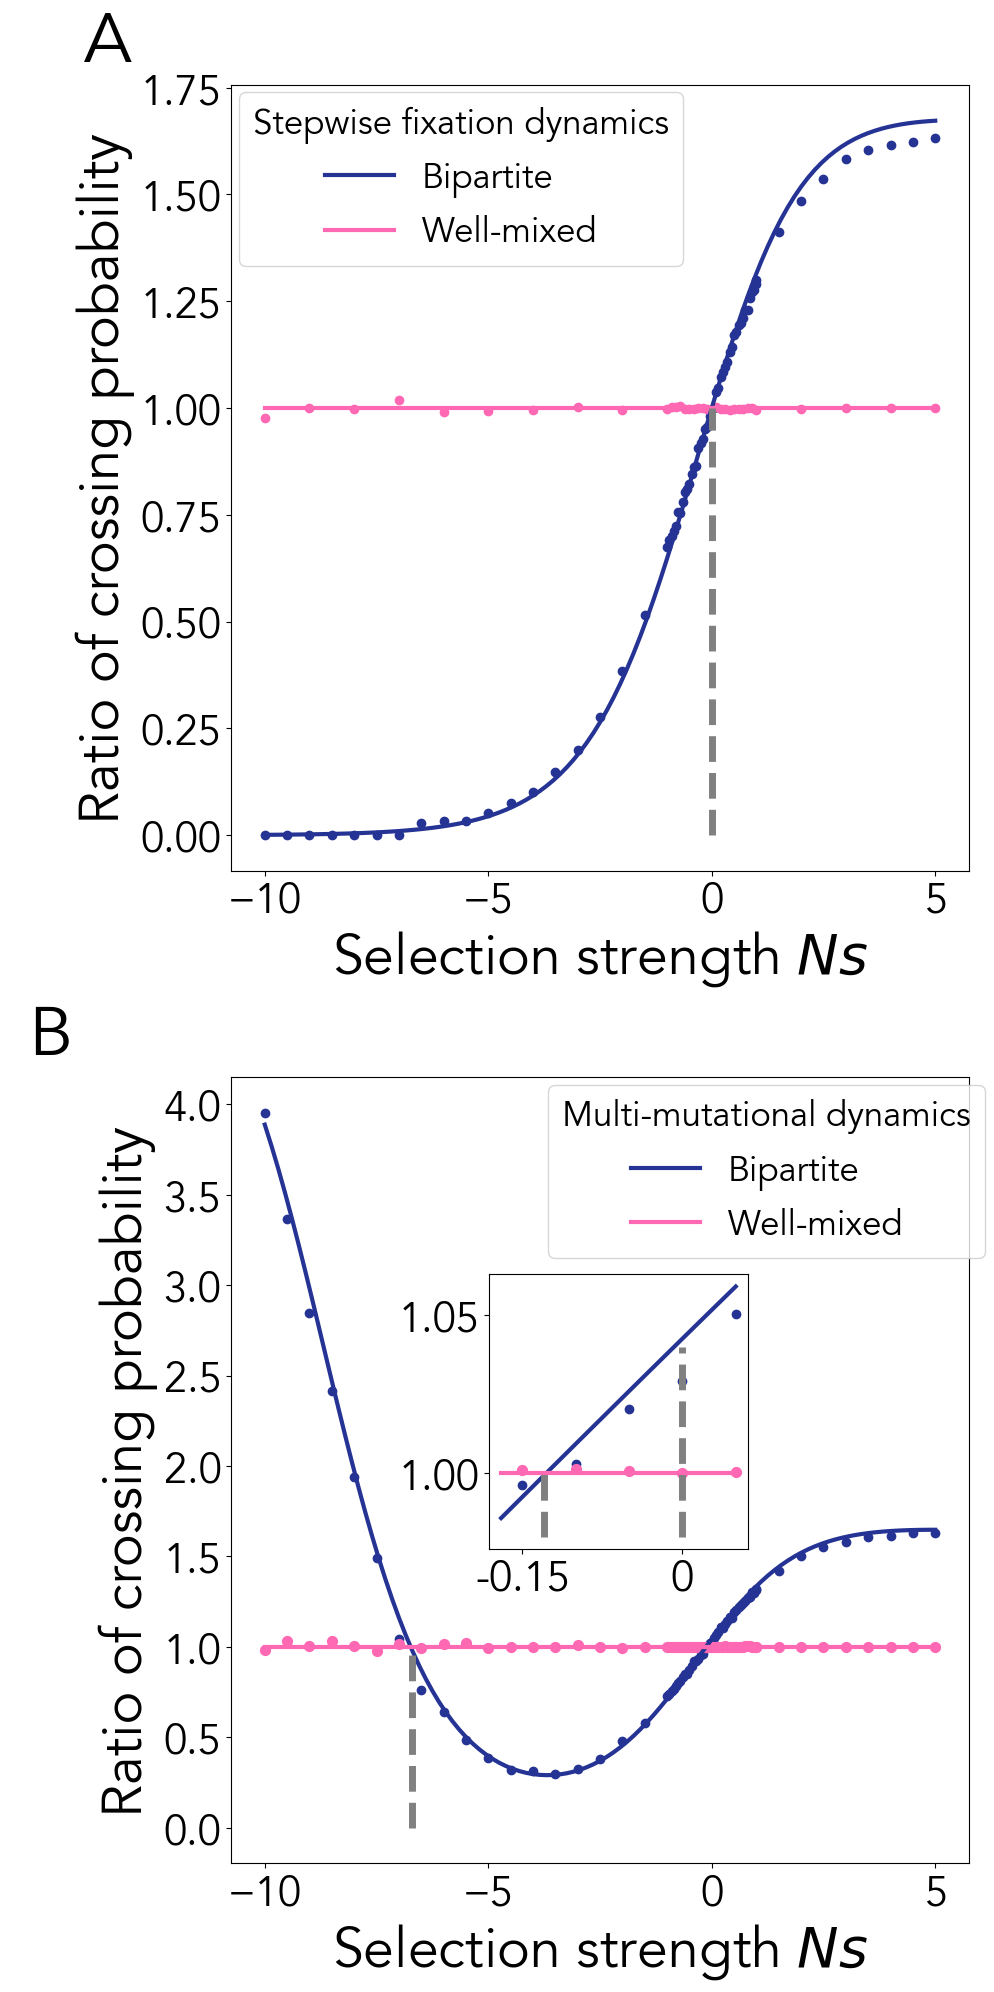

In [4]:
plt.figure(figsize = (10,20))
ax = plt.subplot(211)
ls = np.linspace(-0.1, 0.05,101)
N = 100

data_bd, data_db = process_single('fig3_data/single/bi408', N = 88)
data_bd = data_bd[5:-15]
wm = single(data_bd[:,0], amp = 1, N = N)
plt.scatter(N * data_bd[:,0], data_bd[:,1] / wm, c = '#253494')
wm = single(ls, amp = 1, N = N)
plt.plot(N * ls, single(ls, amp = 1.71434, N = N) / wm, linewidth = 3, c = '#253494', label = 'Bipartite')

data_bd, data_db = process_single('fig3_data/single/wm', N = 47)
data_bd = data_bd[5:-8]
wm = single(data_bd[:,0], amp = 1, N = N)
plt.scatter(N * data_bd[:,0], data_bd[:,1] / wm, c = '#ff69b4')
wm = single(ls, amp = 1, N = N)
plt.plot(N * ls, single(ls, N = N) / wm, linewidth = 3, c = '#ff69b4', label = 'Well-mixed')

plt.plot(2 * [0], [0,1], c = 'grey', linewidth = 5, linestyle = "--")

plt.xticks([-10,-5,0,5], fontsize = 30)
plt.yticks(fontsize = 30)

plt.xlabel('Selection strength $Ns$', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)

plt.legend(title = 'Stepwise fixation dynamics', title_fontsize=25, loc = (0.01,0.77), fontsize = 25)


plt.text(-0.2, 1.03, 'A', fontsize = 50, transform=ax.transAxes)

#####################################################################################
ax = plt.subplot(212)
ls = np.linspace(-0.1, 0.05, 101)
N = 100
mu = 1e-6

data_bd, data_db = process('fig3_data/tunnel/bi408', N = 88)
data_bd = data_bd[5:-15]
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) 
              for s in data_bd[:,0]]) 
plt.scatter(N * data_bd[:,0], data_bd[:,2] / wm, c = '#253494')

wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) for s in ls])
y = np.array([approximate(s = s, N = N, mu = mu, amp = 1.71434, lamb = 0.101161) 
              for s in ls]) 
plt.plot(N * ls, y/wm, linewidth = 3, c = '#253494', label = 'Bipartite')

wm_c = np.array([approximate(s = s, mu = mu, N = N) for s in ls]) 
data_bd, data_db = process('fig3_data/tunnel/wm', N = 88)
data_bd = data_bd [5:-15]
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) 
              for s in data_bd[:,0]]) 
plt.scatter(N * data_bd[:,0], data_bd[:,2] / wm, s = 50, c = '#ff69b4')
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) for s in ls])
plt.plot(N * ls, wm_c / wm, linewidth = 3, c = '#ff69b4', label = 'Well-mixed')

plt.plot(2 * [-6.7], [0, 1], c = 'grey', linewidth = 5, linestyle = "--")

plt.xlabel('Selection strength $Ns$', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)

plt.xticks([-10,-5,0,5], fontsize = 30)
plt.yticks(fontsize = 30)

leg = plt.legend(title = 'Multi-mutational dynamics', title_fontsize=25, 
                 loc = (0.43, 0.77), fontsize = 25)

plt.text(-0.3, 1.03, ' B', fontsize = 50, transform=ax.transAxes)

#####################################################################################

ins = ax.inset_axes([0.35,0.4,0.35,0.35])

ls = np.linspace(-0.0017, 0.0005, 100)

data_bd, data_db = process('fig3_data/tunnel/bi408', N = 88)
data_bd = data_bd[40:45]
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) 
              for s in data_bd[:,0]]) 
ins.scatter(N * data_bd[:,0], data_bd[:,2] / wm, c = '#253494')
y = np.array([approximate(s = s, N = N, mu = mu, amp = 1.71434, lamb = 0.101161) 
              for s in ls]) 
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) 
              for s in ls]) 
ins.plot(N * ls, y / wm, linewidth = 3, c = '#253494')

data_bd, data_db = process('fig3_data/tunnel/wm', N = 88)
data_bd = data_bd[40:45]
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) 
              for s in data_bd[:,0]]) 
ins.scatter(N * data_bd[:,0], data_bd[:,2] / wm, s = 50, c = '#ff69b4')

wm_c = np.array([approximate(s = s, mu = mu, N = N) for s in ls]) 
wm = np.array([approximate(s = s, N = N, mu = mu, amp = 1, lamb = 1) 
              for s in ls]) 
ins.plot(N * ls, wm_c / wm, linewidth = 3, c = '#ff69b4')


ins.plot(2 * [0], [0.98, 1.04], c = 'grey', linewidth = 5, linestyle = "--")

ins.plot(2 * [-0.13], [.98, 1], c = 'grey', linewidth = 5, linestyle = "--")

ins.set_xticks([-0.15, 0], ['-0.15', '0'])
ins.set_yticks([1, 1.05])
ins.tick_params(labelsize=30)

plt.tight_layout()
#plt.savefig('Figure2_ratio_version.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/dn/kt6f6_td4dl2qrsg4wnv22z80000gn/T/ipykernel_63773/4066575796.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


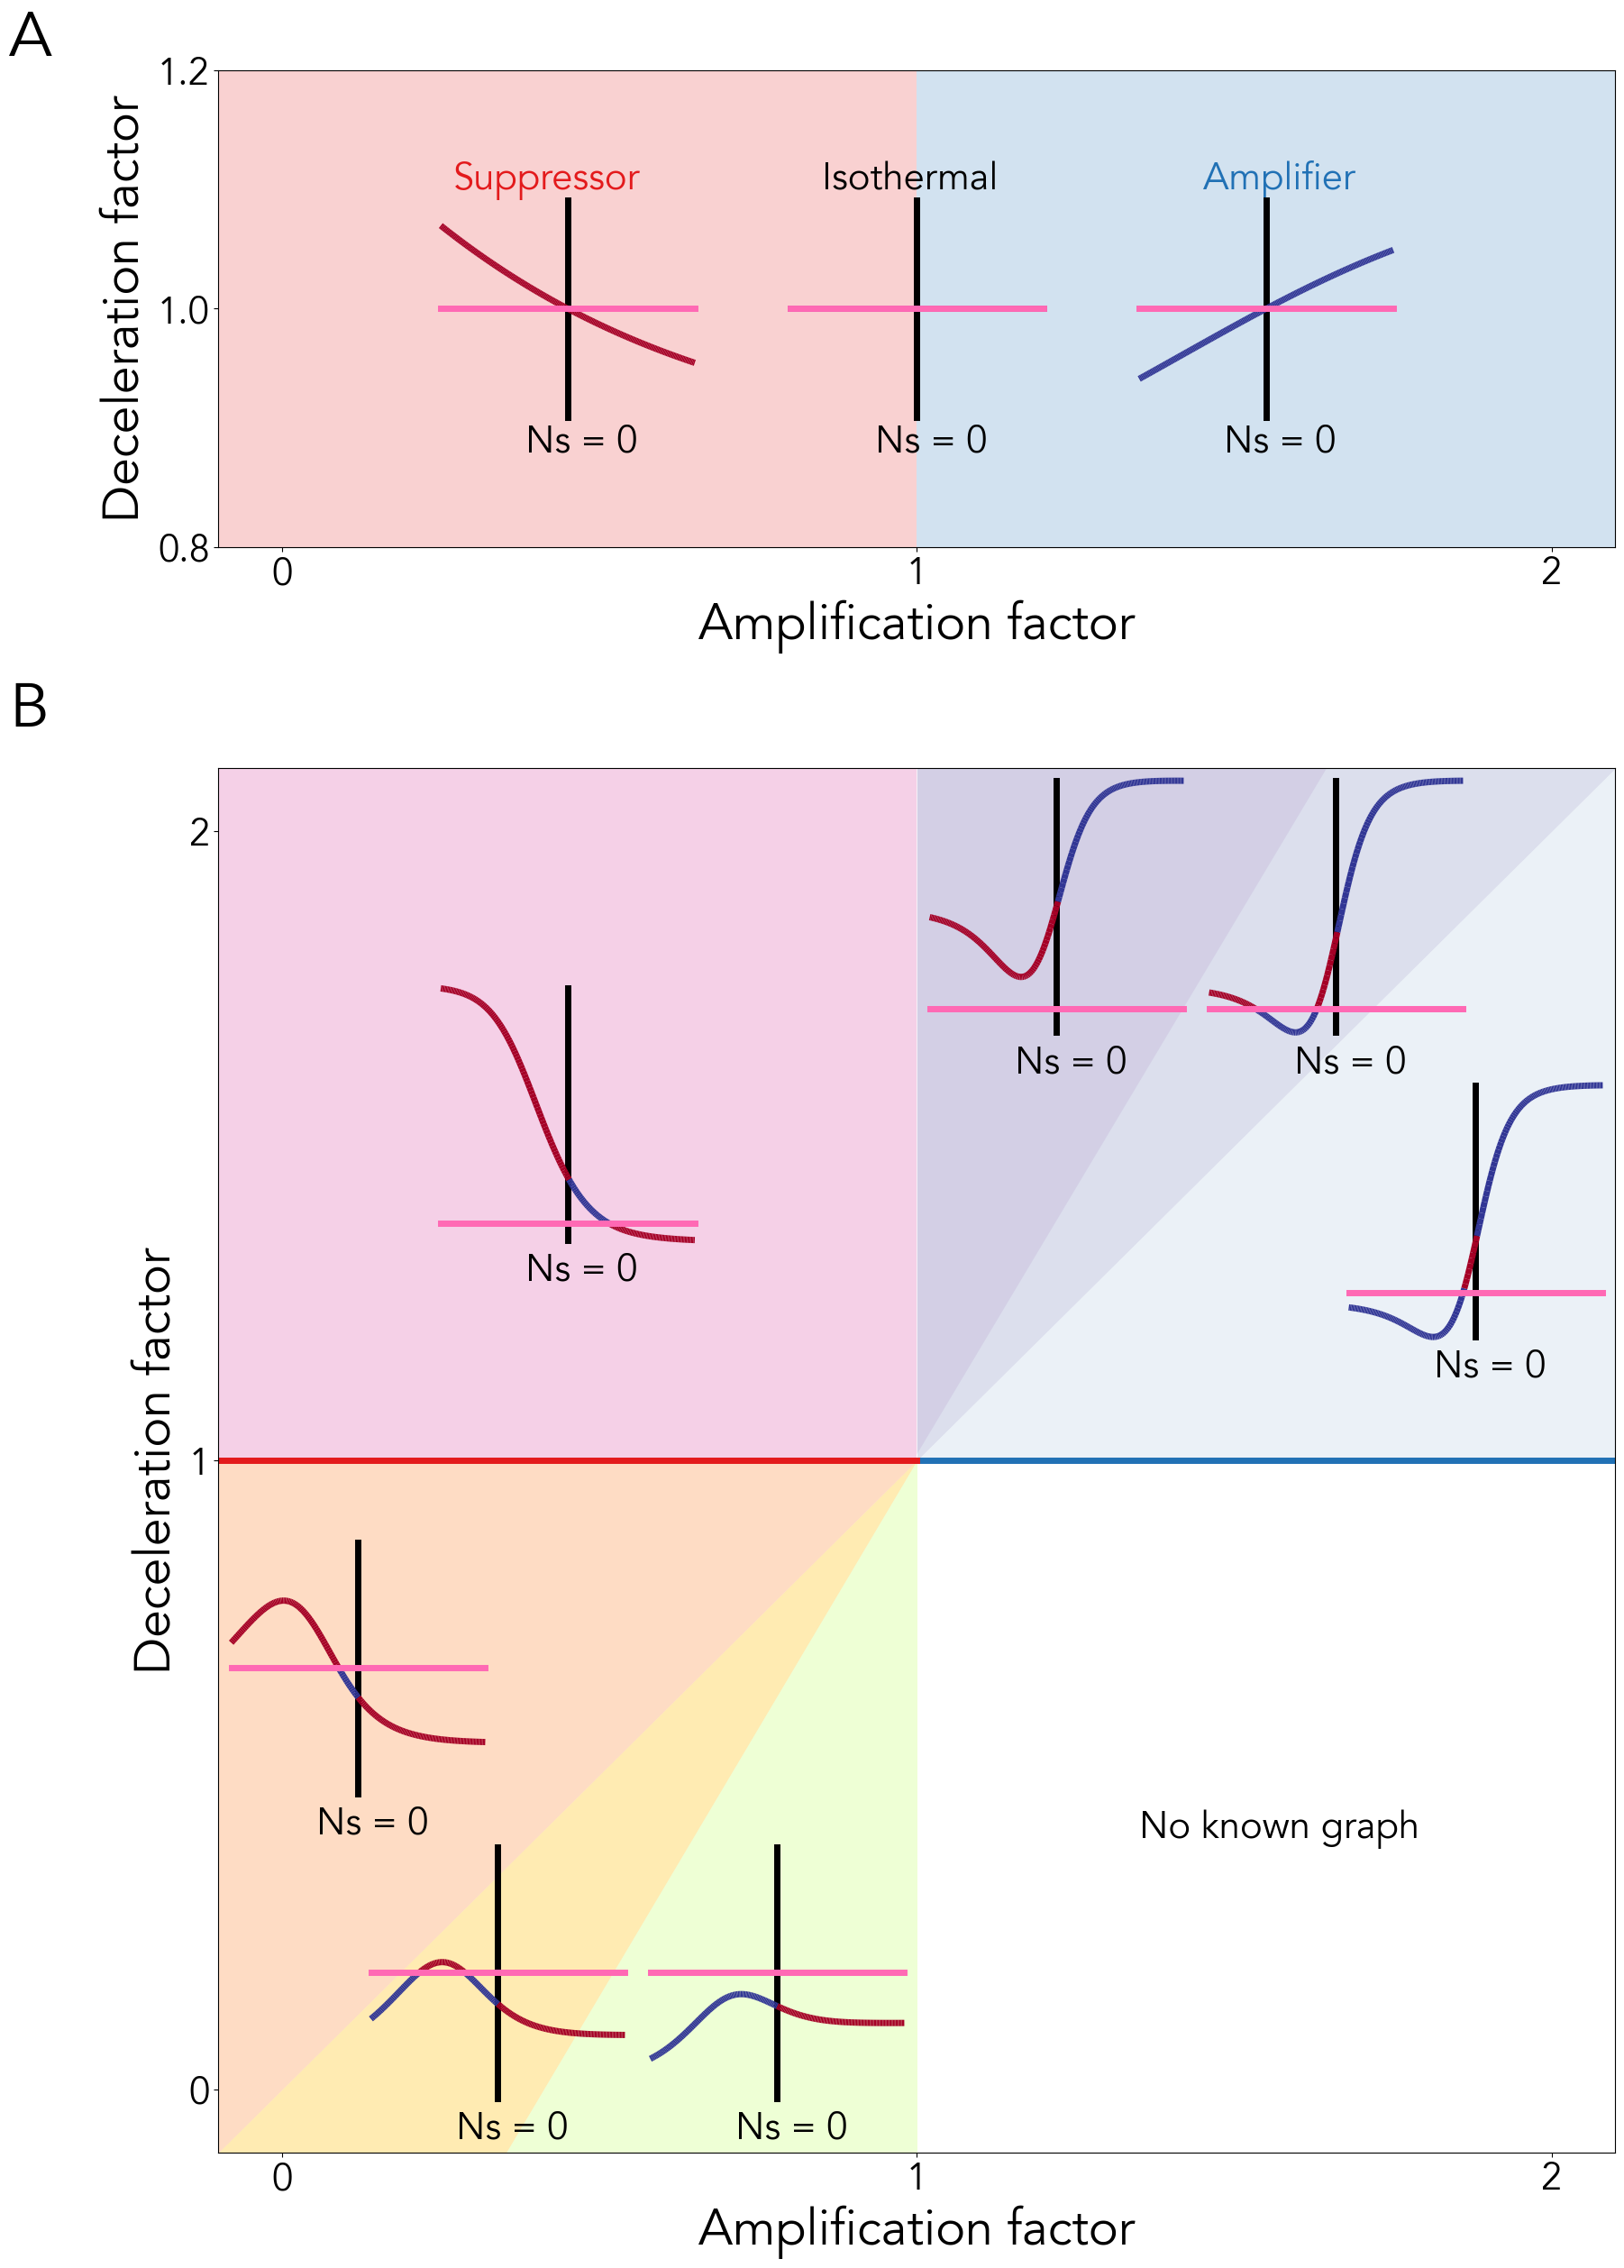

In [5]:
c = ['#c6dbef', '#6baed6', '#4292c6', '#08519c']
sns.set_palette(c[::-1])


plt.figure(figsize = (20,30))

ax = plt.subplot2grid((30,20), (0, 0), rowspan= 7, colspan = 20)
####################################################################
plt.text(1.45, 1.1,'Amplifier', fontsize = 30, c = '#2171b5')
plt.fill_between([0.999,2.1], [.7,.7], [1.3,1.3], alpha = 0.2,
                 linewidth=0.0, color = '#2171b5')

ins = ax.inset_axes([0.65,0.25,0.2,0.5])
s = np.linspace(-0.01,0.01, 200)

y = single(s, N = 100, amp = 1.5)
z = single(s, N = 100, amp = 1)

ins.plot([0,0],[0.6, 1.4], 'k', linewidth = 5)
#ins.plot(1000 * s, y / z, linewidth = 3)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

#ins.plot(1000 * s, y1 / z, color = '#edf8b1')
ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')


####################################################################
plt.text(0.27, 1.1,'Suppressor', fontsize = 30, c = '#e31a1c')
plt.fill_between([-0.1,0.999], [.7,.7], [1.3,1.3], alpha = 0.2,
                 linewidth=0.0, color = '#e31a1c')

ins = ax.inset_axes([0.15,0.25,0.2,0.5])
s = np.linspace(-0.01,0.01, 200)

y = single(s, N = 100, amp = 0.75)
z = single(s, N = 100, amp = 1)

ins.plot([0,0],[0.8, 1.2], 'k', linewidth = 5)
#ins.plot(1000 * s, y / z, linewidth = 3, c = 'r')
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

#ins.plot(1000 * s, y1 / z, color = '#edf8b1')
ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')


####################################################################
plt.text(0.85, 1.1,'Isothermal', fontsize = 30, c = 'k')

ins = ax.inset_axes([0.4,0.25,0.2,0.5])
s = np.linspace(-0.01,0.01, 200)

y = single(s, N = 100, amp = 1)
z = single(s, N = 100, amp = 1)

ins.plot([0,0],[0, 2], 'k', linewidth = 5)
ins.plot(1000 * s, y / z, linewidth = 5)

ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

#ins.plot(1000 * s, y1 / z, color = '#edf8b1')
ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')
####################################################################

plt.xticks([0,1,2],fontsize = 30)
plt.yticks([0.8,1,1.2],fontsize = 30)

plt.xlabel('Amplification factor', fontsize = 40)
plt.ylabel('Deceleration factor', fontsize = 40)

plt.xlim(-0.1,2.1)
plt.ylim(0.8,1.2)
plt.text(-0.15, 1.03, 'A', fontsize = 50, transform=ax.transAxes)

####################################################################
####################################################################

ax = plt.subplot2grid((30,20), (10, 0), rowspan= 20, colspan = 20)

plt.plot([1,2.1],[1,1], c = '#2171b5', linewidth = 5)
plt.plot([-0.1,1],[1,1], c = '#e31a1c', linewidth = 5)


####################################################################
plt.fill_between([0.999,2.1], [1.01, 1 + 1.1 * 1.7], [2.1,2.1], alpha = 0.3,
                 linewidth=0.0, color = '#d4b9da')
ins = ax.inset_axes([0.5,0.8,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 2, lamb = 1 / 3, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[0.9, max(y/z)], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')

####################################################################
plt.fill_between([1,2.1], [1,2.1], [2.1,2.1], alpha = 0.3, 
                 linewidth=0.0, color = '#8c96c6')
ins = ax.inset_axes([0.7,0.8,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 2, lamb = 1 / 2.3, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[0.9, max(y/z)], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')

####################################################################
plt.fill_between([1,2.1], [1, 1], [1,2.1], alpha = 0.3, 
                 linewidth=0.0, color = '#bfd3e6')
ins = ax.inset_axes([0.8,0.58,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 2, lamb = 1 / 2, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[min(y/z), max(y/z)], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')

####################################################################
plt.text(1.35, 0.4,'No known graph', fontsize = 30)
plt.fill_between([1,2.1], [-0.1,-0.1], [1,1], alpha = 0.3, 
                 linewidth=0.0, color = 'w')

####################################################################
plt.fill_between([-0.1,1], [1,1], [2.1,2.1], alpha = 0.3, 
                 linewidth=0.0, color = '#df65b0')
ins = ax.inset_axes([0.15,0.65,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 0.9, lamb = 1 / 2, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[min(y/z), max(y/z)], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')
####################################################################
plt.fill_between([-0.1,1], [-0.1,1], [1,1], alpha = 0.3, 
                 linewidth=0.0, color = '#fd8d3c')
ins = ax.inset_axes([0.,0.25,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 0.4, lamb = 1 / 0.2, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[0, 2], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')

####################################################################
plt.fill_between([-0.1,1], [-0.1,1],[1 - 1.1 * 1.7,1], alpha = 0.3, 
                 linewidth=0.0, color = '#FFBF00')

ins = ax.inset_axes([0.1, 0.03,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 0.5, lamb = 1 / 0.15, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[0, 2], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')

####################################################################
plt.fill_between([-0.1,1], [-0.1,-0.1], [1 - 1.1 * 1.7,1], alpha = 0.2, 
                 linewidth=0.0, color = '#ADFF2F')

ins = ax.inset_axes([0.3, 0.03,0.2,0.2])
s = np.linspace(-0.01,0.01, 201)
y = np.array([approximate(s = s, mu = 1e-6, amp = 0.6, lamb = 1 / 0.1, N = 1000) for s in s])
z = np.array([approximate(s = s, mu = 1e-6, N = 1000) for s in s])

ins.plot([0,0],[0, 2], 'k', linewidth = 5)
color_line(1000 * s, y / z, (y - z) * (s) > 0, ins)
ins.plot([-10,10],[1,1], '#ff69b4', linewidth = 5)

ins.text(0.35,-0.1,'Ns = 0', fontsize = 30, transform = ins.transAxes)
ins.patch.set_alpha(0)
ins.axis('off')

####################################################################
plt.xticks([0,1,2],fontsize = 30)
plt.yticks([0,1,2],fontsize = 30)

plt.xlim(-0.1,2.1)
plt.ylim(-0.1,2.1)
plt.xlabel('Amplification factor', fontsize = 40)
plt.ylabel('Deceleration factor', fontsize = 40)

plt.text(-0.15, 1.03, 'B', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Figure 4

In [6]:
x = np.linspace(0.2, 2.2, 200)
y = np.geomspace(0.8, 129, 200)

X, Y = np.meshgrid(x, y)

s = -0.01
mu = 1e-5
x, y = X.ravel(), Y.ravel()

Z = np.array([approximate(s = s, mu = mu, amp = x[i], lamb = 1 / y[i]) 
              for i in range(x.size)])
Z = Z.reshape(X.shape[0], X.shape[1])
Z_r = 1 / (mu * 100 * Z)
Z = Z / approximate(s = s, mu = mu, amp = 1, lamb = 1)

Z_t = np.array([approximate_t(s = s, mu = mu, amp = x[i], lamb = 1 / y[i]) 
              for i in range(x.size)])
Z_t = Z_t.reshape(X.shape[0], X.shape[1])
Z_r += Z_t
Z_t = Z_t / approximate_t(s = s, mu = mu, amp = 1, lamb = 1)


Z_r = (1 / (mu * 100 * approximate(s = s, mu = mu, amp = 1, lamb = 1))
             + approximate_t(s = s, mu = mu, amp = 1, lamb = 1))/ Z_r

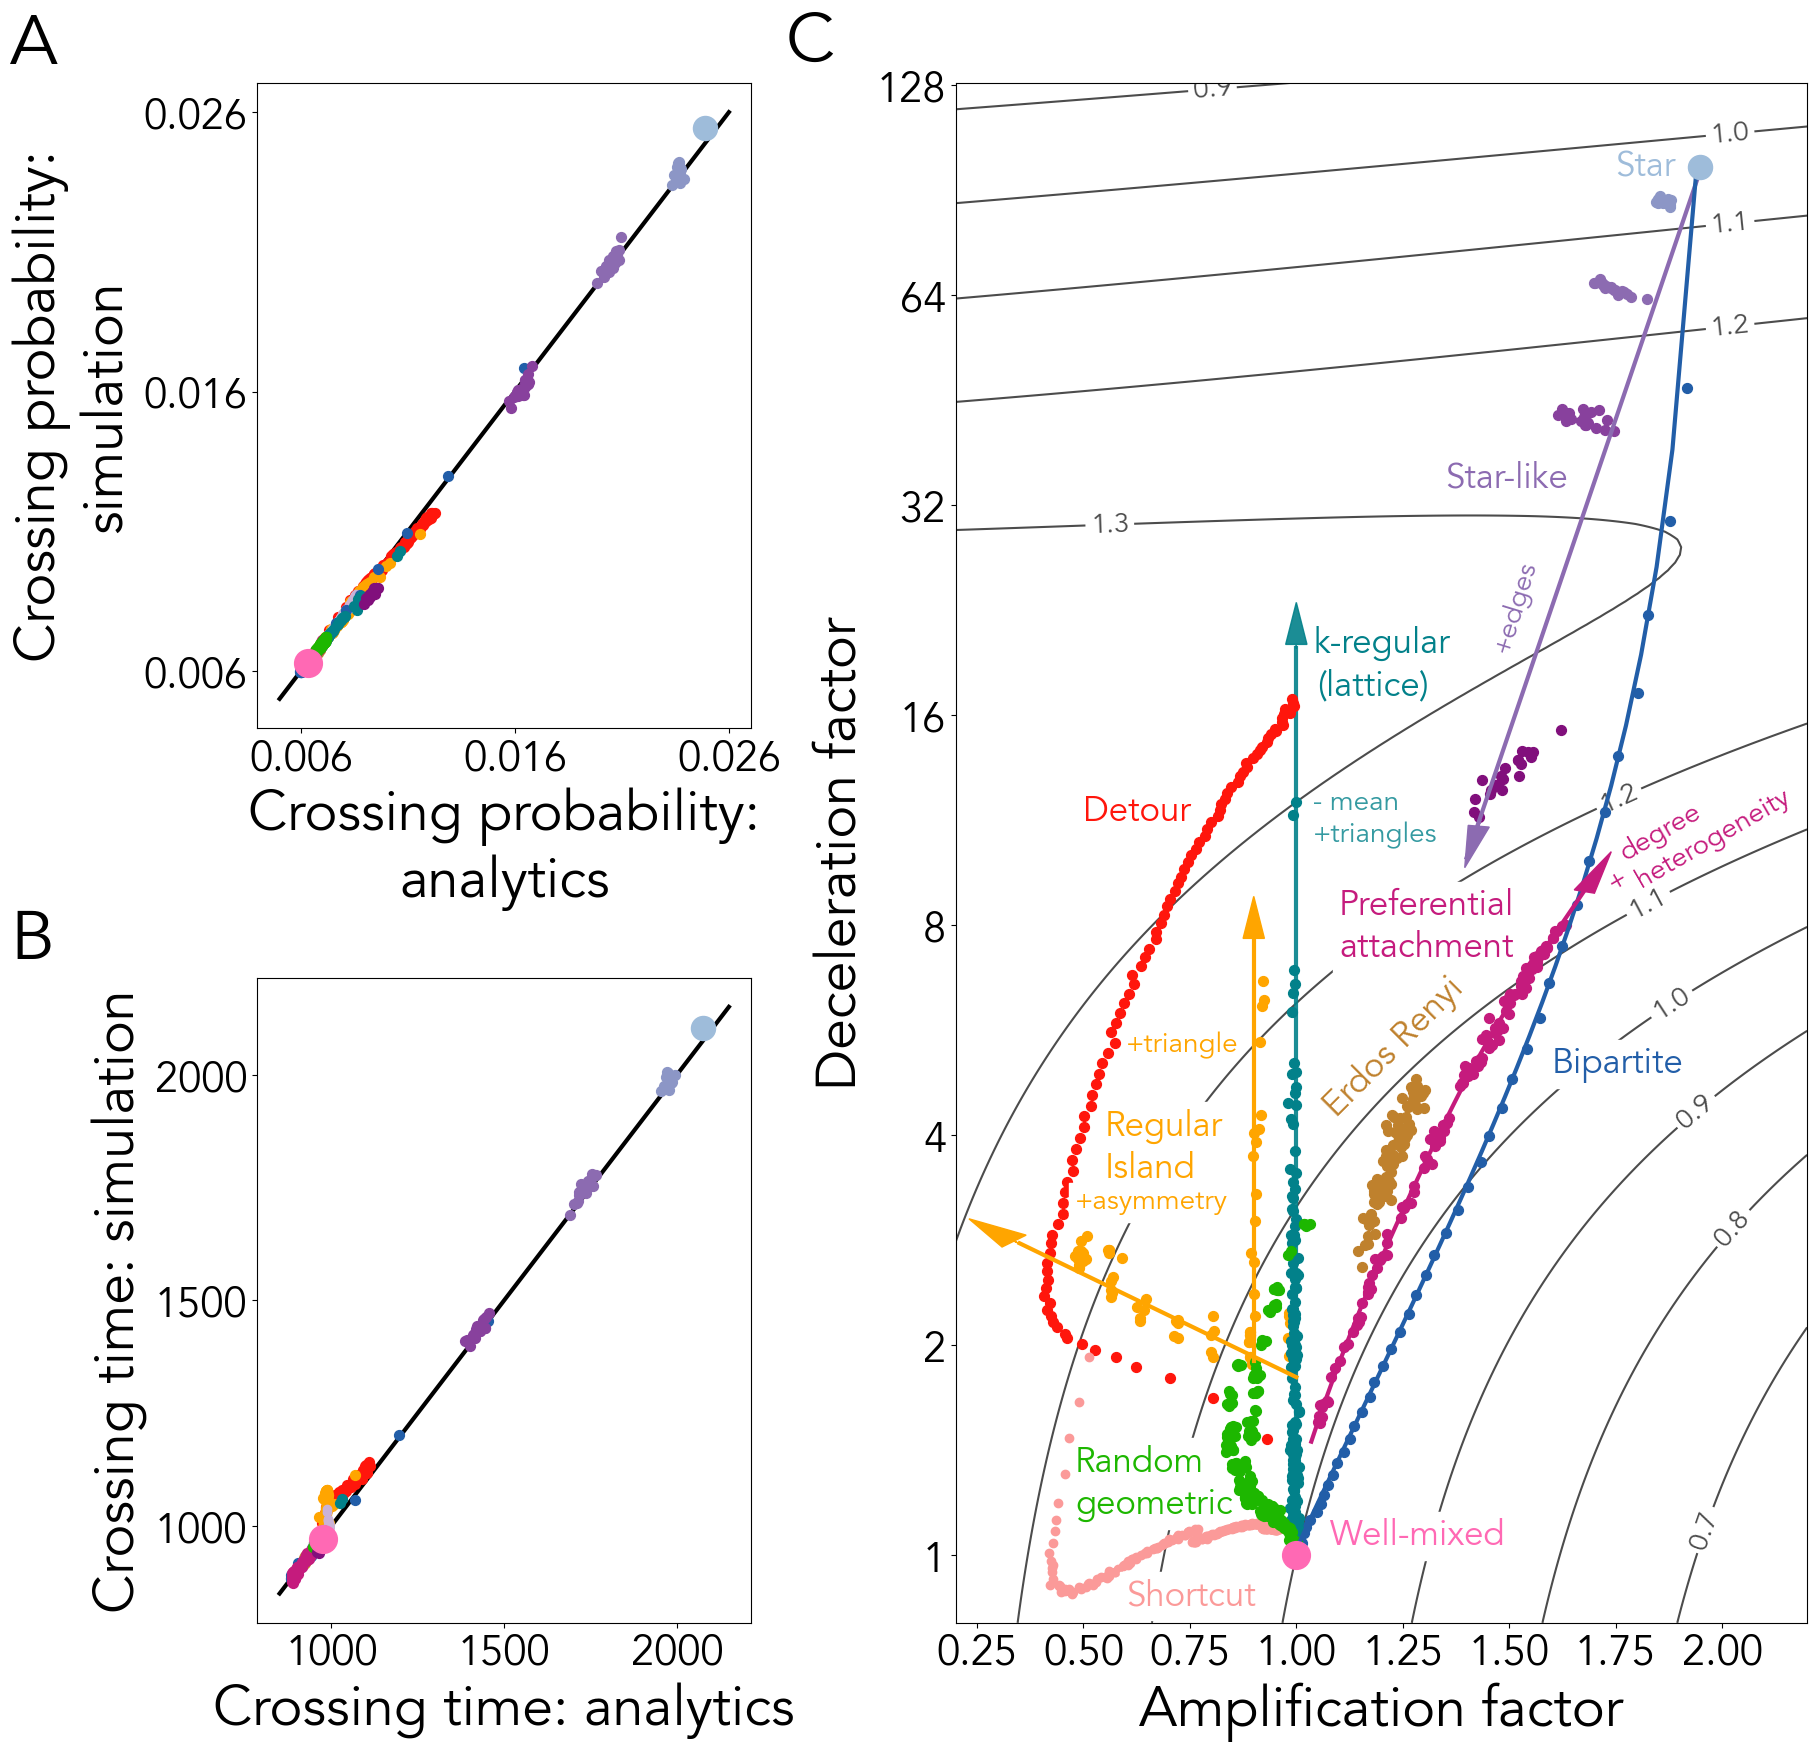

In [7]:
plt.figure(figsize = (20,20))

ax = plt.subplot2grid((100, 100), (0, 0), colspan = 32, rowspan=42)
plt.text(-0.5, 1.03, 'A', fontsize = 50, transform=ax.transAxes)

data = np.loadtxt('fig4_data/combined_bd_factors.txt')
y, _ = process('fig4_data/combined', 1800)
y = y[:,2]
x = [approximate(s = -0.01, mu = 1e-5, amp=d[0], lamb = d[1]) for d in data]

plt.scatter(x[800:1200:2], y[800:1200:2], s = 50, 
            color = '#02818a', zorder = 2)

plt.scatter(x[1600:], y[1600:], s = 50, color = '#c51b7d', 
            label = 'PA', zorder = 2)

plt.scatter(x[1200:1400], y[1200:1400], s = 50, 
            color = '#1DB700', zorder = 2)

plt.scatter(x[70:100], y[70:100], s = 50, color = '#bf812d')

plt.scatter(x[100:198], y[100:198], s = 50, color = '#FF160C')
plt.scatter(x[1400:1600], y[1400:1600],
            s = 50, color = '#FFA500')

plt.scatter(x[620:640], y[620:640], s = 50, color = '#8c96c6', zorder = 2)
plt.scatter(x[660:680], y[660:680], s = 50, color = '#8c6bb1', zorder = 2)
plt.scatter(x[700:720], y[700:720], s = 50, color = '#88419d', zorder = 2)
plt.scatter(x[780:800], y[780:800], s = 50, color = '#810f7c', zorder = 2)

plt.scatter(x[198], y[198], s = 300, color = '#9ebcda',zorder = 3)

plt.scatter(x[357:600], y[357:600], c = '#cab2d6')

plt.scatter(x[297:346], y[297:346], s = 50, color = '#225ea8')

plt.scatter(x[100], y[100], s = 400, color = '#ff69b4',zorder = 3)

plt.plot([0.005,0.026], [0.005,0.026], linewidth = 3, c = 'k', zorder = -1)
plt.xlabel('Crossing probability:\nanalytics',fontsize = 40)
plt.ylabel('Crossing probability:\nsimulation', fontsize = 40)

plt.xticks([0.006, 0.016, 0.026],fontsize = 30)
plt.yticks([0.006, 0.016, 0.026], fontsize = 30)

################################################################################
################################################################################
ax = plt.subplot2grid((100, 100), (58, 0), colspan = 32, rowspan=42)
plt.text(-0.5, 1.03, 'B', fontsize = 50, transform=ax.transAxes)

data = np.loadtxt('fig4_data/combined_bd_factors.txt')
y, _ = process('fig4_data/combined', 1800)
y = y[:,3] / 100
x = np.array([approximate_t(s = -0.01, mu = 1e-5, amp=d[0], lamb = d[1]) 
              for d in data] ) /100

plt.scatter(x[800:1200:2], y[800:1200:2], s = 50, 
            color = '#02818a', zorder = 2)

plt.scatter(x[1600:], y[1600:], s = 50, color = '#c51b7d', 
            label = 'PA', zorder = 2)

plt.scatter(x[1200:1400], y[1200:1400], s = 50, 
            color = '#1DB700', zorder = 2)

plt.scatter(x[70:100], y[70:100], s = 50, color = '#bf812d')

plt.scatter(x[100:198], y[100:198], s = 50, color = '#FF160C')
plt.scatter(x[1400:1600], y[1400:1600],
            s = 50, color = '#FFA500')

plt.scatter(x[620:640], y[620:640], s = 50, color = '#8c96c6', zorder = 2)
plt.scatter(x[660:680], y[660:680], s = 50, color = '#8c6bb1', zorder = 2)
plt.scatter(x[700:720], y[700:720], s = 50, color = '#88419d', zorder = 2)
plt.scatter(x[780:800], y[780:800], s = 50, color = '#810f7c', zorder = 2)

plt.scatter(x[198], y[198], s = 300, color = '#9ebcda',zorder = 3)

plt.scatter(x[357:600], y[357:600], c = '#cab2d6')

plt.scatter(x[297:346], y[297:346], s = 50, color = '#225ea8')

plt.scatter(x[100], y[100], s = 400, color = '#ff69b4',zorder = 3)

plt.plot([850, 2150], [850, 2150], linewidth = 3, c = 'k', zorder = -1)

plt.xlabel('Crossing time: analytics',fontsize = 40)
plt.ylabel('Crossing time: simulation', fontsize = 40)

plt.xticks([1000, 1500, 2000],fontsize = 30)
plt.yticks([1000, 1500, 2000], fontsize = 30)


################################################################################
################################################################################
ax = plt.subplot2grid((100, 100), (0, 45), colspan = 55, rowspan=100)

contours = plt.contour(X, np.log2(Y), Z_r, colors='black', 
                       #levels = [0.8, 0.9, 1, 1.05], 
                       alpha = 0.7, zorder = -1)
plt.clabel(contours, inline=True, fontsize=20, fmt='%.1f')

########################################
factors = np.loadtxt('fig4_data/combined_bd_factors.txt')
factors[:,1] = np.log2(factors[:,1])

plt.scatter(factors[800:1200:2,0], -factors[800:1200:2,1], s = 50, 
            color = '#02818a', zorder = 2)

plt.plot([1, 1], np.log2([1,20]), color = '#02818a', zorder = 1, linewidth = 3, alpha = 0.9)
plt.arrow(1, np.log2(18.6), 0, 0.02, width= .0, head_length= 0.2, alpha = 0.9,
          head_width = .05, head_starts_at_zero = True, color = '#02818a')

ax.text(1.04,4.3, 'k-regular', fontsize = 25, color = '#02818a',
        zorder = 3)
ax.text(1.05,4.1, '(lattice)', fontsize = 25, color = '#02818a',
        zorder = 3)
ax.text(1.04, 3.55, '- mean', fontsize = 20, color = '#02818a', alpha = 0.8,
        zorder = 3)
ax.text(1.04, 3.4, '+triangles', fontsize = 20, color = '#02818a', alpha = 0.8,
        zorder = 3)

########################################
x,y = factors[1600:,0], -factors[1600:,1]
plt.scatter(x[(x>1.05) * (x<1.8)], y[(x>1.05) * (x<1.8)], 
            s = 50, color = '#c51b7d', label = 'PA', zorder = 2)

ax.text(1.1, 2.85, 'Preferential\nattachment', fontsize = 25,
         color = '#c51b7d', backgroundcolor='w', zorder = 1)

ax.text(1.75, np.log2(9.1), 'degree\nheterogeneity', fontsize = 20,
         color = '#c51b7d', zorder = 1, rotation = 30)
ax.text(1.72, np.log2(9.), '+', fontsize = 20,
         color = '#c51b7d', zorder = 1, rotation = 30)

x,y = trans(factors[1600:,0], -factors[1600:,1], pad = [0,0.05])
plt.plot(x[10:], y[10:], linewidth = 3, color = '#c51b7d', zorder = 3)

plt.arrow(1.635, np.log2(8.2), 0.01, 0.03, width= .0, head_length= 0.2,
          head_width = .05, head_starts_at_zero = True, color = '#c51b7d',zorder = 3)
########################################

plt.scatter(factors[1200:1400,0], -factors[1200:1400,1], s = 50, 
            color = '#1DB700', zorder = 2)
ax.text(.48, 0.2, 'Random\ngeometric', fontsize = 25, rotation = 0, backgroundcolor='w',
         color = '#1DB700', zorder = 1)

########################################

plt.scatter(factors[0:60,0], -factors[0:60,1], s = 50, color = '#bf812d')
plt.scatter(factors[70:100,0], -factors[70:100,1], s = 50, color = '#bf812d')
ax.text(1.05, 2.1, 'Erdos Renyi', fontsize = 25, rotation = 45,
        color = '#bf812d', zorder = 3)
########################################

plt.scatter(factors[100:198,0], -factors[100:198,1], s = 50, color = '#FF160C')
ax.text(0.5, 3.5, 'Detour', fontsize = 25,
        color = '#FF160C', backgroundcolor='w', zorder = 3)

########################################
plt.scatter(factors[620:640,0], -factors[620:640,1], s = 50, color = '#8c96c6', zorder = 2)
plt.scatter(factors[660:680,0], -factors[660:680,1], s = 50, color = '#8c6bb1', zorder = 2)
plt.scatter(factors[700:720,0], -factors[700:720,1], s = 50, color = '#88419d', zorder = 2)
plt.scatter(factors[780:800,0], -factors[780:800,1], s = 50, color = '#810f7c', zorder = 2)
plt.plot([1.4, 1.95], np.log2([10, 97]), linewidth = 3, color = '#8c6bb1')
plt.arrow(1.45, 3.6, -0.005, -0.03, width= .0, head_length= 0.2,
          head_width = .05, head_starts_at_zero = True, color = '#8c6bb1',zorder = 3)

plt.scatter(factors[198,0], -factors[198,1], s = 300, color = '#9ebcda',zorder = 3)
ax.text(1.75, np.log2(95), 'Star', fontsize = 25, color = '#9ebcda',
        zorder = 3)
ax.text(1.35, np.log2(34), 'Star-like', fontsize = 25, color = '#8c6bb1',
        zorder = 3)
ax.text(1.45, np.log2(20), '+edges', fontsize = 20, color = '#8c6bb1', rotation = 73,
        zorder = 3)

########################################

idx = (np.arange(0,200) % 20 < 5)
plt.scatter(factors[1400:1600][idx,0], -factors[1400:1600][idx,1], s = 50, color = '#FFA500')
plt.scatter(factors[1400:1600][20:40,0], -factors[1400:1600][20:40,1], s = 50, color = '#FFA500')
plt.plot([0.35,1], np.log2([2.8,1.8]), linewidth = 3, color = '#FFA500')
plt.plot([0.9,0.9], np.log2([1.9,8]), linewidth = 3, color = '#FFA500')
plt.arrow(0.9, np.log2(7), 0, 0.03, width= .0, head_length= 0.2,
          head_width = .05, head_starts_at_zero = True, color = '#FFA500',zorder = 3)
plt.arrow(0.4, np.log2(2.7), -0.01, 0.01, width= .0, head_length= 0.15,
          head_width = .08, head_starts_at_zero = True, color = '#FFA500',zorder = 3)

ax.text(.55, 1.8, 'Regular\nIsland', fontsize = 25, rotation = 0, backgroundcolor='w',
         color = '#FFA500', zorder = 3)
ax.text(.6, 2.4, '+triangle', fontsize = 20, rotation = 0,
         color = '#FFA500', zorder = 3)
ax.text(.48, 1.65, '+asymmetry', fontsize = 20, rotation = 0,backgroundcolor='w',
         color = '#FFA500', zorder = 3)

########################################
plt.scatter(factors[357:600,0], -factors[357:600,1], c = '#fb9a99')
ax.text(.6, np.log2(0.85), 'Shortcut', fontsize = 25, rotation = 0, backgroundcolor='w',
         color = '#fb9a99', zorder = 3)
########################################

plt.scatter(factors[297:346,0], -factors[297:346,1], s = 50, color = '#225ea8')

factors = np.loadtxt('fig4_data/param_ap_bd_factors.txt')
factors[:,1] = np.log2(factors[:,1])
plt.plot(factors[400:450,0], -factors[400:450,1], linewidth = 3, color = '#225ea8')

ax.text(1.6, 2.3, 'Bipartite', fontsize = 25, 
         color = '#225ea8', backgroundcolor='w', zorder = 3)

########################################
plt.scatter(1, 0, s = 400, color = '#ff69b4',zorder = 3)
ax.text(1.08,0.05, 'Well-mixed', fontsize = 25, color = '#ff69b4', backgroundcolor='w',
        zorder = 3)
########################################

plt.xticks(fontsize = 30)
plt.yticks(np.log2([1, 2, 4, 8, 16, 32, 64,128]), 
           [1, 2, 4, 8, 16, 32, 64, 128], fontsize = 30)
plt.xlabel('Amplification factor', fontsize = 40)
plt.ylabel('Deceleration factor', fontsize = 40)

plt.text(-0.2, 1.014, 'C', fontsize = 50, transform=ax.transAxes)
#plt.savefig('Figures/Fig6.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


# Figure 5

In [8]:
def process(key, N = 100, approx = False):
    path = ""
    #N = 100
    data_bd = np.zeros((3*N,3))
    raw_bd = np.loadtxt(path + key + '_results_bd.txt')
    raw_bd = np.vstack([raw_bd[::3,:], raw_bd[1::3,:], raw_bd[2::3,:] ])

    data_bd[:,0] = raw_bd[:,0]
    data_bd[:,1] = raw_bd[:,2] / (raw_bd[:,1] + raw_bd[:,2])
    data_bd[:,2] = raw_bd[:,4] #/ raw_bd[:,2]
    data_bd[:,2][np.where(data_bd[:,2] == 0)] = np.nan    
    data_db = np.zeros((3*N,3))
    raw_db = np.loadtxt(path + key + '_results_db.txt')
    raw_db = np.vstack([raw_db[::3,:], raw_db[1::3,:], raw_db[2::3,:] ])

    data_db[:,0] = raw_db[:,0]
    data_db[:,1] = raw_db[:,2] / (raw_db[:,1] + raw_db[:,2])
    data_db[:,2] = raw_db[:,4] #/ raw_db[:,2]
    data_db[:,2][np.where(data_db[:,2] == 0)] = np.nan 
    
    print("done")
    return data_bd, data_db

def out():
    raw = np.zeros((2 * 51 * 4, 4))

    data_bd = np.zeros((51 * 4, 4))
    data_db = np.zeros((51 * 4, 4))

    for i in range(2040):
        data = np.loadtxt('fig5_data/complex_s_results/%g.txt'%i)
        raw[2 * (i % 204): 2 * (i % 204 + 1), :3] += data[:,[0,1,2]]
        raw[2 * (i % 204): 2 * (i % 204 + 1), 3] += data[:,2] * data[:,4]

    raw[:,0] = raw[:,0] / 10
    raw[:,3] = raw[:,3] / raw[:,2]

    data_bd[:,[0,2]] = raw[::2,[0,3]]
    data_bd[:,1] = raw[::2,2] / (raw[::2,1] + raw[::2,2])  

    data_db[:,[0,2]] = raw[1::2,[0,3]] 
    data_db[:,1] = raw[1::2,2] / (raw[1::2,1] + raw[1::2,2])  
    
    return data_bd, data_db


def out_mu():
    raw = np.zeros((2 * 51 * 4, 4))

    data_bd = np.zeros((51 * 4, 4))
    data_db = np.zeros((51 * 4, 4))
    count = np.zeros(51 * 4 * 2)
    
    for i in range(2040):
        try:
            data = np.loadtxt('fig5_data/complex_mu_results/%g.txt'%i)
            raw[2 * (i % 204): 2 * (i % 204 + 1), :3] += data[:,[0,1,2]]
            raw[2 * (i % 204): 2 * (i % 204 + 1), 3] += data[:,2] * data[:,4]
            count[2 * (i % 204): 2 * (i % 204 + 1)] += 1
        except:
            print(i)
            
    raw[:,0] = raw[:,0] / count
    raw[:,3] = raw[:,3] / raw[:,2]

    data_bd[:,[0,2]] = raw[::2,[0,3]]
    data_bd[:,1] = raw[::2,2] / (raw[::2,1] + raw[::2,2])  

    data_db[:,[0,2]] = raw[1::2,[0,3]] 
    data_db[:,1] = raw[1::2,2] / (raw[1::2,1] + raw[1::2,2])  
    
    return data_bd, data_db

In [9]:
data = []
for i in range(0,800):
    try:
        g = nx.read_edgelist('fig5_data/complex_graphs/{:d}.txt'.format(i), data=False)
        deg = np.array(g.degree())[:,1].astype(int)
        data += [(deg.mean(), deg.std(), nx.transitivity(g))]
    except:    
        print(i)
data = np.array(data)

factors = np.loadtxt('fig5_data/pt_bd_factors.txt')

done


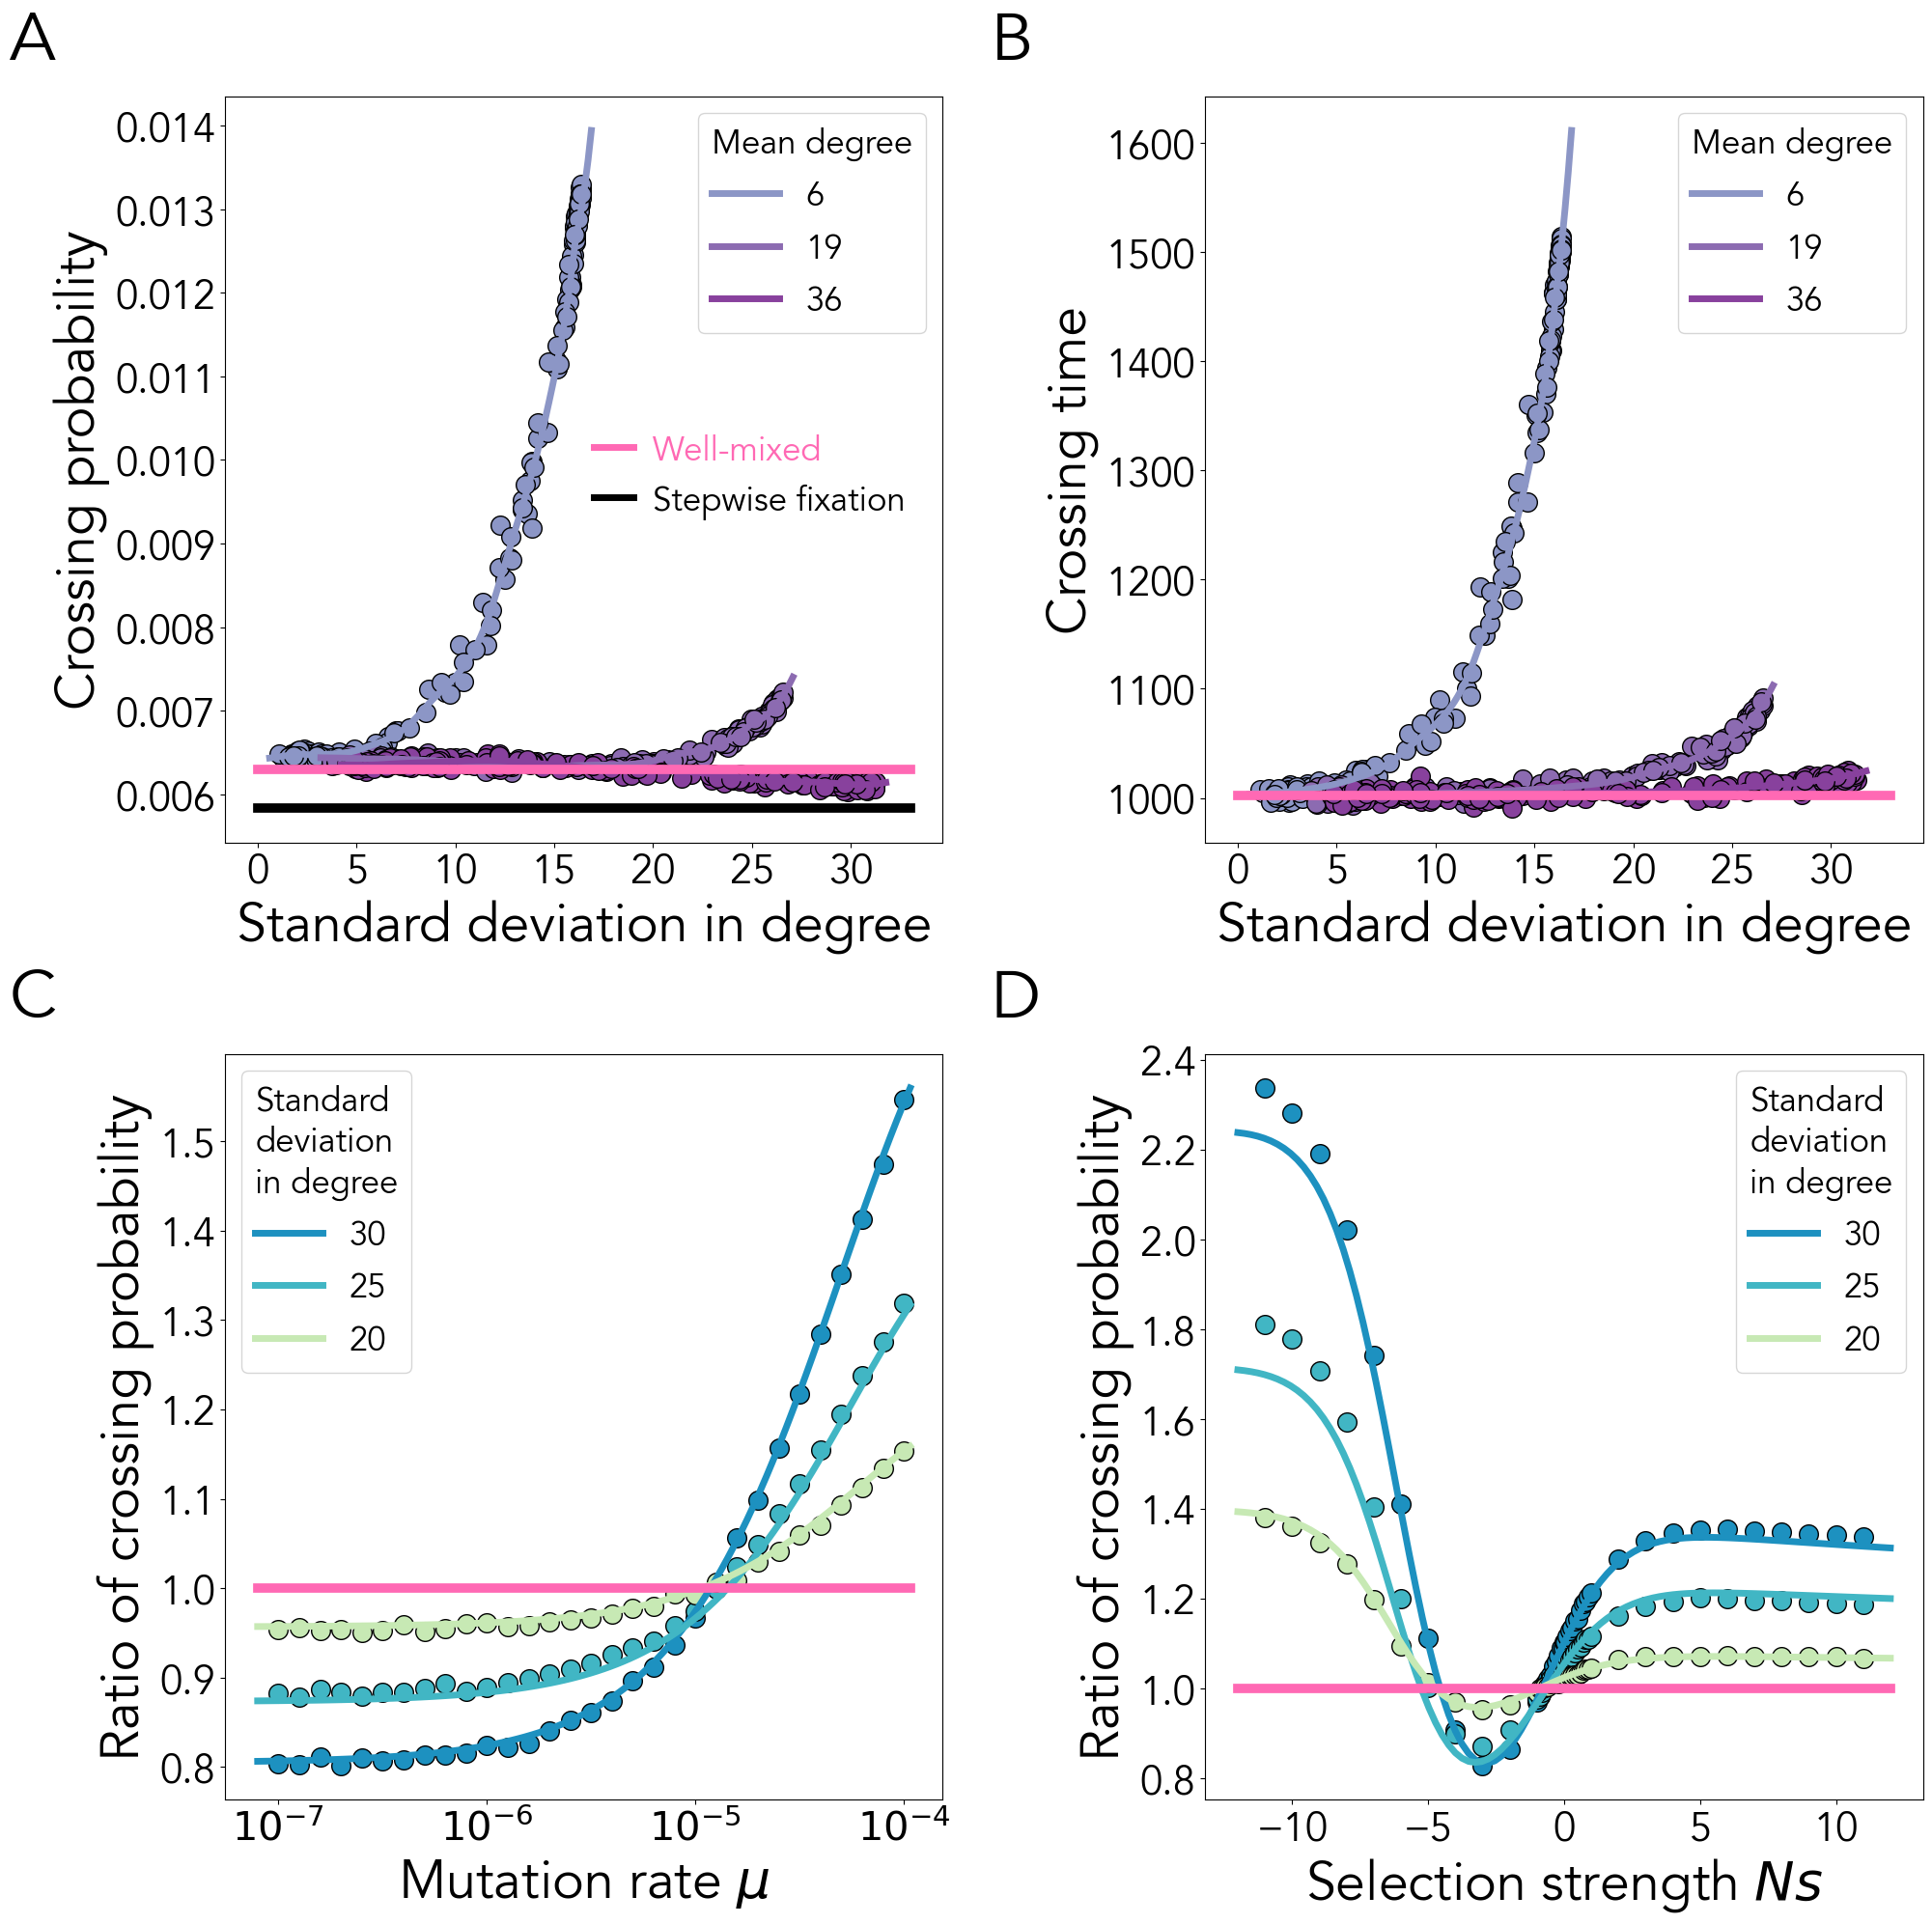

In [10]:
plt.figure(figsize = (20,20))
c = ['#8c96c6','#8c6bb1', '#88419d']
sns.set_palette(c)


mu = 1e-5
results_bd, results_db = process('fig5_data/complex_neg5', 800)

ax = plt.subplot(221)
plt.plot([0,33], 2 * [approximate(s = -0.01, mu = mu)],  color = '#ff69b4', linewidth = 7, zorder = 10)
plt.plot([0,33], 2 * [0.005832],  color = 'k', linewidth = 7, zorder = 10)
for i in range(3):
    x = data[200 * i:200 * (i + 1), 1]
    y = results_bd[200 * i + 800:200 * (i + 1) + 800,1]
    
    plt.scatter(x[::1], y[::1], linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[200 * i:200 * (i + 1),0], 0.1, [0.5, 0.5])
    x_approx, lamb = trans(x, factors[200 * i:200 * (i + 1), 1], 0.6, [0.5, 0.5])
    
    y_approx = [approximate(s = -0.01, mu = mu, amp = amp[i], lamb = lamb[i]) 
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5, 
                label = int(np.around(data[200 * i, 0],0)) )

#plt.ylim(0.009,0.0225)

plt.plot([17,19], 2 * [0.01015],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(20, 0.01, 'Well-mixed', c = '#ff69b4', fontsize = 25)

plt.plot([17,19], 2 * [0.00955], color = 'k', linewidth = 5, zorder = 10)
plt.text(20, 0.0094, 'Stepwise fixation', fontsize = 25)

plt.xlabel('Standard deviation in degree', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Crossing probability', fontsize = 40)

leg = plt.legend(fontsize = 25,
          title = 'Mean degree', title_fontsize=25, loc = 'upper right')
leg._legend_box.align = "left"
plt.text(-0.3, 1.05, 'A', fontsize = 50, transform=ax.transAxes)

##################################################################
ax = plt.subplot(222)
plt.plot([0,33], 2 * [approximate_t(s = 0, mu = mu) / 100],  
         color = '#ff69b4', linewidth = 7, zorder = 10)
for i in range(3):
    x = data[200 * i:200 * (i + 1), 1]
    y = results_bd[200 * i:200 * (i + 1),2]  / 100
    
    plt.scatter(x, y, linewidth = 1, s = 200, edgecolor = 'k')
    
    x_approx, amp = trans(x, factors[200 * i:200 * (i + 1),0], 0.1, [0.5, 0.5])
    x_approx, lamb = trans(x, factors[200 * i:200 * (i + 1), 1], 0.6, [0.5, 0.5])
    
    y_approx = [approximate_t(s = 0, mu = mu, amp = amp[i], lamb = lamb[i]) / 100
                for i in range(len(amp))]
    plt.plot(x_approx, y_approx, linewidth = 5, 
                label = int(np.around(data[200 * i, 0],0)) )

plt.xlabel('Standard deviation in degree', fontsize = 40)
plt.ylabel('Crossing time', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)

leg = plt.legend(fontsize = 25,
          title = 'Mean degree', title_fontsize=25, loc = 'upper right')
leg._legend_box.align = "left"


plt.text(-0.35, 1.05, '  B', fontsize = 50, transform=ax.transAxes)


##################################################################
c = ['#1d91c0', '#41b6c4', '#c7e9b4', ]

sns.set_palette(c)
mu = 1e-5

ax = plt.subplot(224)

data_bd, _ = out()
wm = np.array([approximate(s = s, mu = mu) for s in data_bd[4:51-4,0]]) 
ls = np.linspace(-0.12, 0.12,100)
wm_c = np.array([approximate(s = s, mu = mu) for s in ls]) 


i = 567
plt.scatter(100 * data_bd[4:51-4,0], data_bd[4:51-4,1] / wm, linewidth = 1, s = 200, 
            edgecolor = 'k', label='_nolegend_')
y = np.array([approximate(s = s, mu = 1e-5, amp = factors[i, 0], lamb = factors[i, 1]) 
              for s in ls]) 
plt.plot(100 * ls, y / wm_c, linewidth = 5)

i = 514
plt.scatter(100 * data_bd[51 + 4:102-4,0], data_bd[51 + 4:102-4,1] / wm, linewidth = 1, s = 200, 
            edgecolor = 'k', label='_nolegend_')
y = np.array([approximate(s = s, mu = 1e-5, amp = factors[i, 0], lamb = factors[i, 1]) 
              for s in ls]) 
plt.plot(100 * ls, y / wm_c, linewidth = 5)


i = 510
plt.scatter(100 * data_bd[102 + 4:153-4,0], data_bd[102 + 4:153-4,1] / wm, linewidth = 1, s = 200, 
            edgecolor = 'k', label='_nolegend_')
y = np.array([approximate(s = s, mu = 1e-5, amp = factors[i, 0], lamb = factors[i, 1]) 
              for s in ls]) 
plt.plot(100 * ls, y / wm_c, linewidth = 5)


plt.plot([-12,12],[1,1], linewidth =7, c = '#ff69b4')

plt.xlabel('Selection strength $Ns$', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks([-10,-5,0,5,10],fontsize = 30)

leg = plt.legend(['30', '25', '20'], fontsize = 25,
          title = 'Standard\ndeviation\nin degree', title_fontsize=25, loc = 'upper right')
leg._legend_box.align = "left"

plt.text(-0.35, 1.05, '  D', fontsize = 50, transform=ax.transAxes)

##################################################################
data_bd, _ = out_mu()

mu = np.linspace(-7,-4,31)
wm = np.array([approximate(s = -0.01, mu = 10**(mu)) for mu in mu]) 

mu_c = np.linspace(-7.1, -3.97, 101)
wm_c = np.array([approximate(s = -0.01, mu = 10**(mu)) for mu in mu_c]) 

ax = plt.subplot(223)

i = 567
plt.scatter(mu, data_bd[:51 - 20:,1][::-1] / wm, linewidth = 1, s = 200, 
            edgecolor = 'k', label='_nolegend_')
y = np.array([approximate(s = -0.01, mu = 10**(mu), amp = factors[i,0], lamb = factors[i,1]) 
                 for mu in mu_c]) 
plt.plot(mu_c, y / wm_c, linewidth = 5)

i = 514
plt.scatter(mu, data_bd[51:102 - 20,1][::-1] / wm,  linewidth = 1, s = 200, 
            edgecolor = 'k', label='_nolegend_')
y = np.array([approximate(s = -0.01, mu = 10**(mu), amp = factors[i,0], lamb = factors[i,1]) 
                 for mu in mu_c]) 
plt.plot(mu_c, y / wm_c, linewidth = 5)

i = 510
plt.scatter(mu, data_bd[102:153 - 20,1][::-1] / wm, linewidth = 1, s = 200, 
            edgecolor = 'k', label='_nolegend_')
y = np.array([approximate(s = -0.01, mu = 10**(mu), amp = factors[i,0], lamb = factors[i,1]) 
                 for mu in mu_c]) 
plt.plot(mu_c, y/ wm_c,  linewidth = 5)


plt.plot(mu_c, wm_c/ wm_c, linewidth = 7, c = '#ff69b4')


plt.xlabel('Mutation rate $\\mu$', fontsize = 40)
plt.ylabel('Ratio of crossing probability', fontsize = 40)
plt.xticks([-7,-6,-5,-4],["$10^{-7}$", "$10^{-6}$", "$10^{-5}$", "$10^{-4}$",],fontsize = 30)
plt.yticks(fontsize = 30)

leg = plt.legend(['30', '25', '20'], fontsize = 25,
          title = 'Standard\ndeviation\nin degree', title_fontsize=25, loc = 'upper left')
leg._legend_box.align = "left"

plt.text(-0.3, 1.05, 'C', fontsize = 50, transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Figure 6

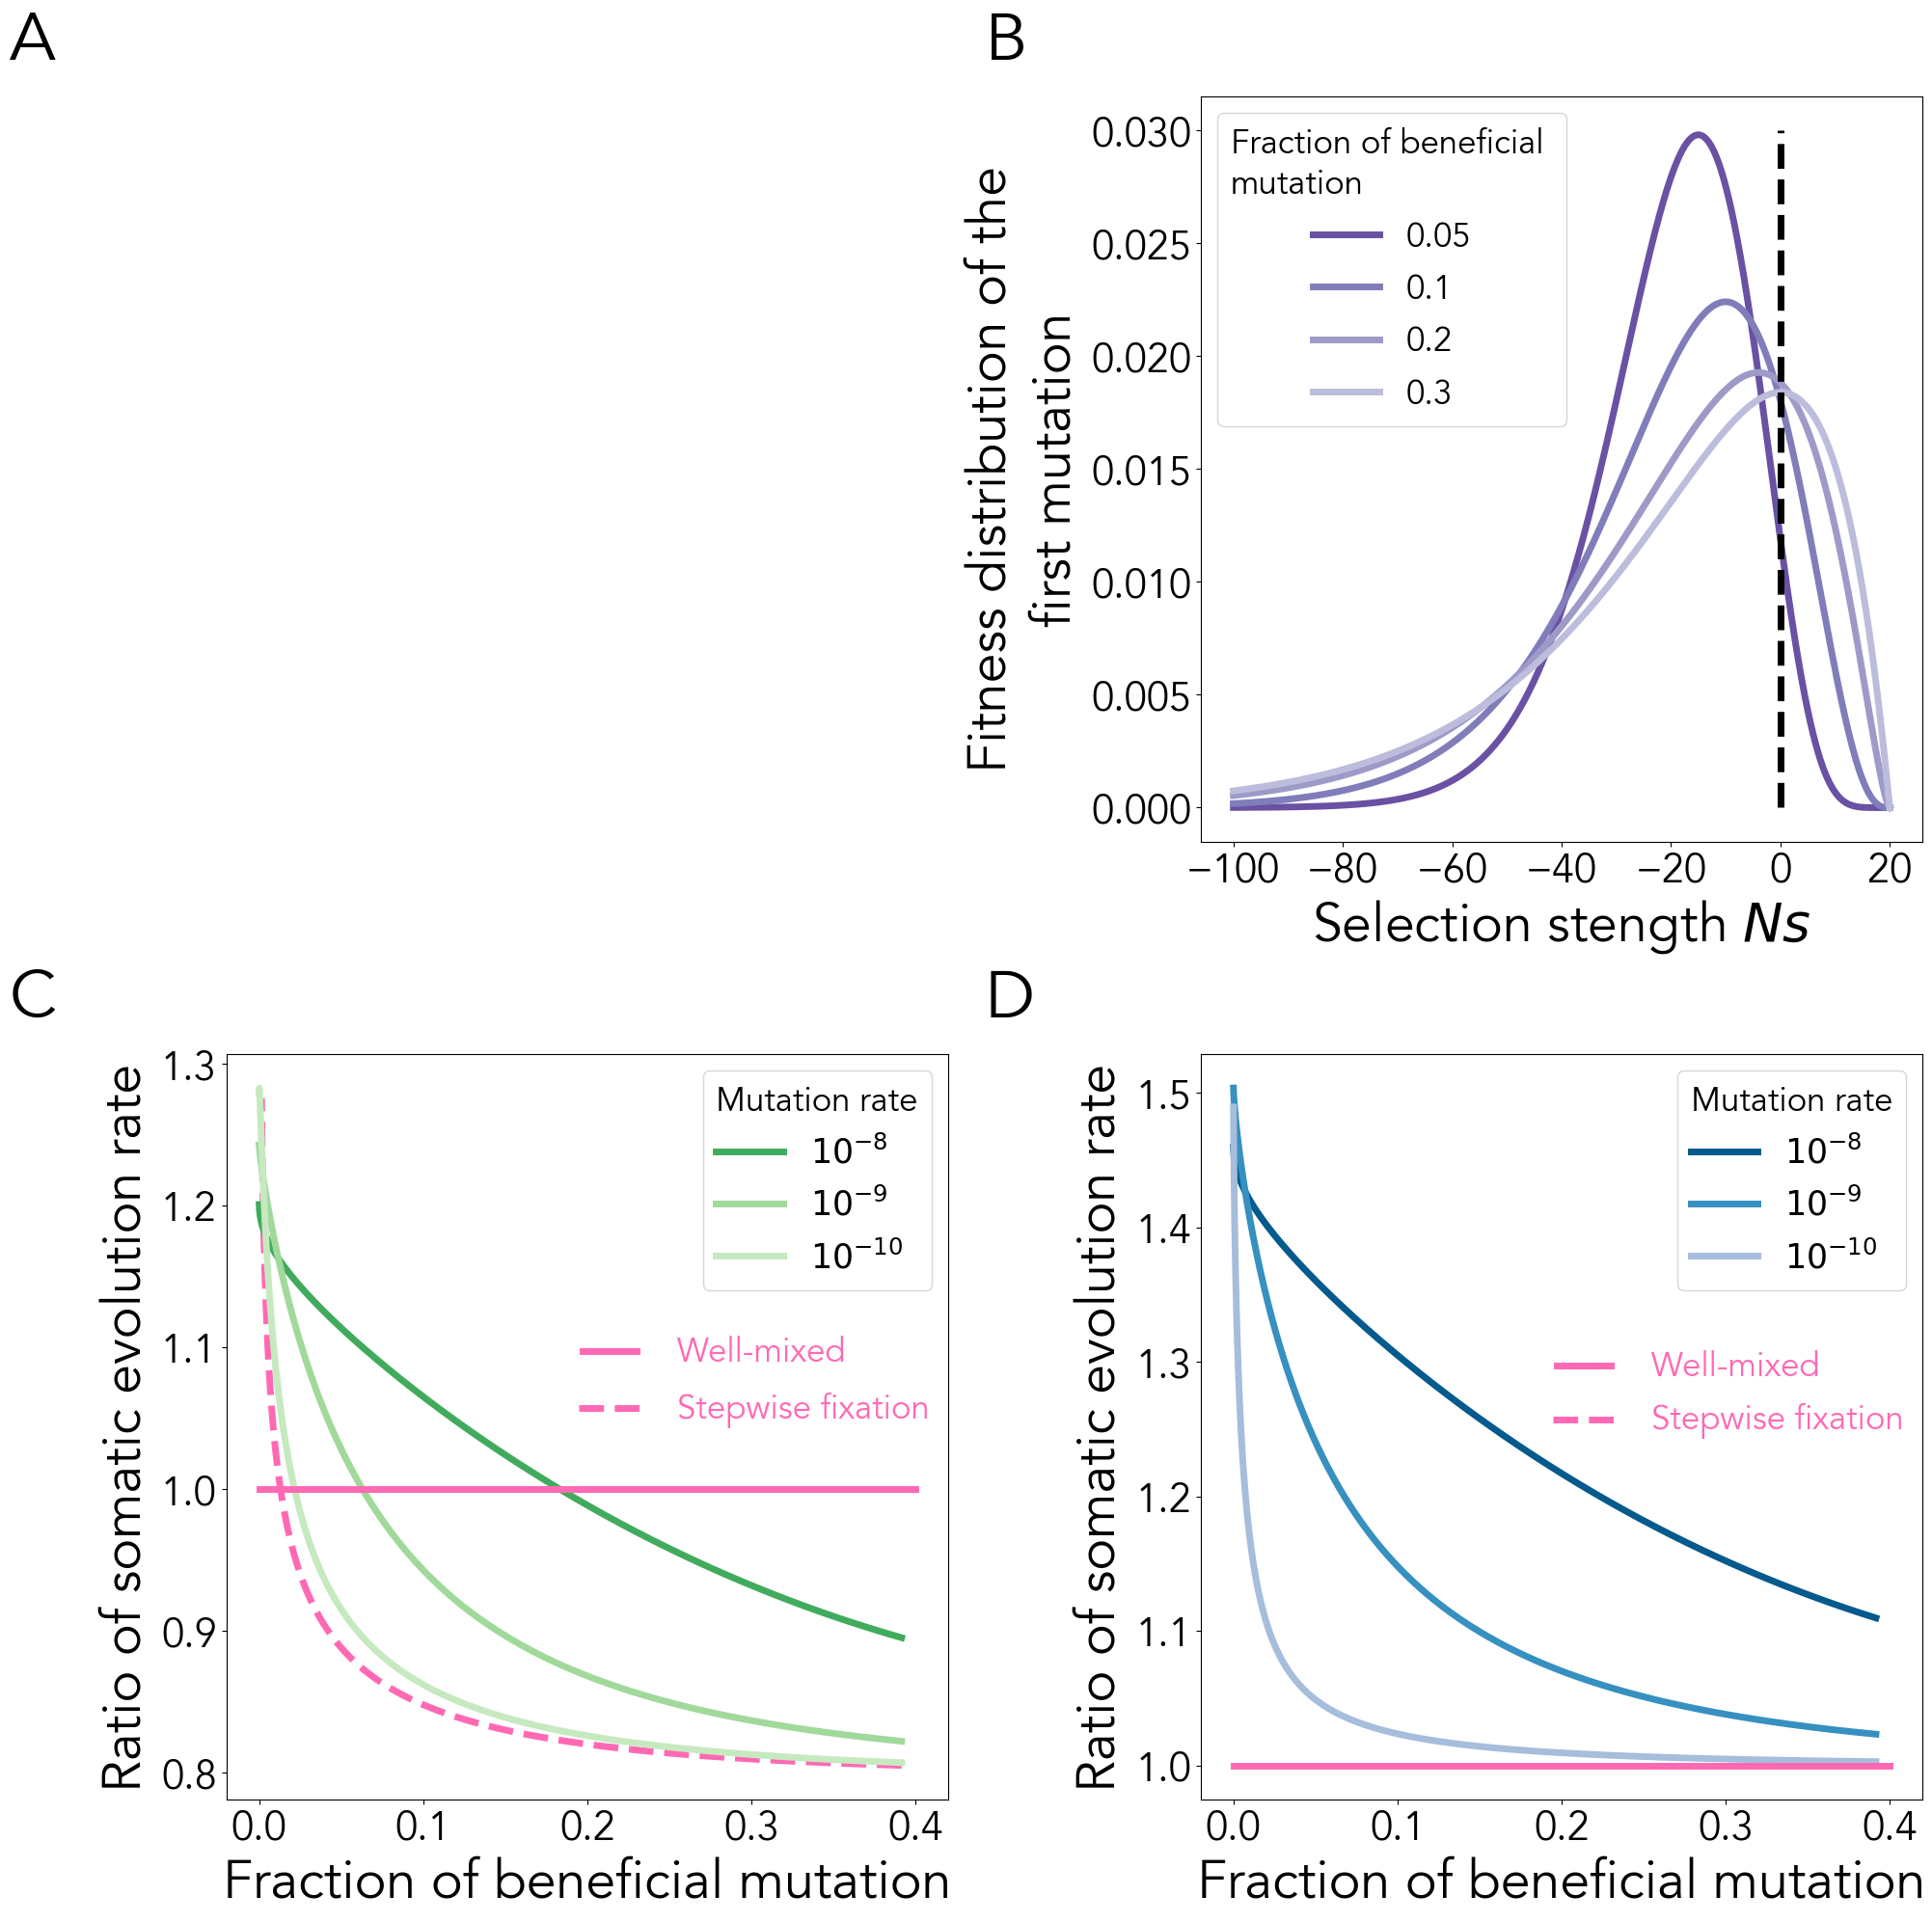

In [11]:
plt.figure(figsize = (20,20))
ax = plt.subplot(221)
ax.axis('off')
plt.text(-0.3, 1.05, 'A', fontsize = 50, transform=ax.transAxes)
#############################################################################################
#############################################################################################

c = ['#bcbddc','#9e9ac8','#807dba', '#6a51a3'][::-1]
sns.set_palette(c)
ax = plt.subplot(222)
x = np.linspace(-300,20,3201)

param = (8, 5)
ps = gamma.pdf(-x, a=param[0], loc = -20, scale = param[1])
stats = (np.sum(ps[:3000]) / 10, gamma.cdf(0, a=param[0], loc = -20, scale = param[1]))
plt.plot(x[2000:], ps[2000:], label = '%.1g'%stats[1], linewidth = 5)
#print(gamma.stats(a=param[0], loc = -20, scale = param[1]))

param = (4, 10)
ps = gamma.pdf(-x, a=param[0], loc = -20, scale = param[1])
stats = (np.sum(ps[:3000]) / 10, gamma.cdf(0, a=param[0], loc = -20, scale = param[1]))
plt.plot(x[2000:], ps[2000:], label = '%.1g'%stats[1], linewidth = 5)
#print(gamma.stats(a=param[0], loc = -20, scale = param[1]))

param = (2.5, 16)
ps = gamma.pdf(-x, a=param[0], loc = -20, scale = param[1])
stats = (np.sum(ps[:3000]) / 10, gamma.cdf(0, a=param[0], loc = -20, scale = param[1]))
plt.plot(x[2000:], ps[2000:], label = '%.1g'%stats[1], linewidth = 5)
#print(gamma.stats(a=param[0], loc = -20, scale = param[1]))

param = (2, 20)
ps = gamma.pdf(-x, a=param[0], loc = -20, scale = param[1])
stats = (np.sum(ps[:3000]) / 10, gamma.cdf(0, a=param[0], loc = -20, scale = param[1]))
plt.plot(x[2000:], ps[2000:], label = '%.1g'%stats[1], linewidth = 5)
#print(gamma.stats(a=param[0], loc = -20, scale = param[1]))

plt.plot([-0,-0], [0, 0.03], c = 'k', linestyle = '--', linewidth = 5)

plt.xlabel('Selection stength $Ns$', fontsize = 40)
plt.ylabel('Fitness distribution of the\nfirst mutation', fontsize = 40)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)

#plt.xlim(-50,30)

plt.legend(title = 'Fraction of beneficial \nmutation', fontsize = 25, title_fontsize=25)

plt.text(-0.35, 1.05, '  B', fontsize = 50, transform=ax.transAxes)

##############################################################################################
##############################################################################################
c = ['#41ab5d','#a1d99b','#c7e9c0']
sns.set_palette(c)

ax = plt.subplot(223)

la = np.geomspace(1.01,40,500)
lscale = 40 / la

N = 50000
x = np.linspace(-300,20,3200)
mu = 1e-8
pwm = large(s = x / N, mu = mu, amp = 1, lamb = 1, N = N)
pfix = large(s = x / N, mu = mu, amp = 0.8, lamb = 1, N = N)

lp = np.array([gamma.cdf(0, a=param[0], loc = -20, scale = param[1]) for param in zip(la, lscale)])
lps = np.array([gamma.pdf(-x, a=param[0], loc = -20, scale = param[1])for param in zip(la, lscale)])

plt.plot(lp, (np.sum(lps * pfix, axis = 1) * 0.1)/(np.sum(lps * pwm, axis = 1) * 0.1), 
         linewidth = 5)

mu = 1e-9
pwm = large(s = x / N, mu = mu, amp = 1, lamb = 1, N = N)
pfix = large(s = x / N, mu = mu, amp = 0.8, lamb = 1, N = N)

plt.plot(lp, (np.sum(lps * pfix, axis = 1) * 0.1)/(np.sum(lps * pwm, axis = 1) * 0.1), 
         linewidth = 5)

mu = 1e-10
pwm = large(s = x / N, mu = mu, amp = 1, lamb = 1, N = N)
pfix = large(s = x / N, mu = mu, amp = 0.8, lamb = 1, N = N)

plt.plot(lp, (np.sum(lps * pfix, axis = 1) * 0.1)/(np.sum(lps * pwm, axis = 1) * 0.1), 
         linewidth = 5)

pwm = single(s = x / N, amp = 1, N = N)
pfix = single(s = x / N, amp = 0.8, N = N)
plt.plot(lp[:-70], ((np.sum(lps * pfix, axis = 1) * 0.1)/(np.sum(lps * pwm, axis = 1) * 0.1))[:-70], 
          c = '#ff69b4', linestyle = '--', linewidth = 5, zorder = -1)

plt.plot([0,0.40],[1,1], linewidth = '5',c = '#ff69b4')

plt.yticks(fontsize = 30)
plt.xticks([0,0.1,0.2,0.3,0.4],fontsize = 30)

plt.ylabel('Ratio of somatic evolution rate', fontsize = 40)
plt.xlabel('Fraction of beneficial mutation', fontsize = 40)

plt.plot([0.197,0.23], 2 * [1.097],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(0.255, 1.09, 'Well-mixed', c = '#ff69b4', fontsize = 25)

plt.plot([0.195,0.235], 2 * [1.057], color = '#ff69b4', linestyle = '--', linewidth = 5, zorder = 10)
plt.text(0.255, 1.05, 'Stepwise fixation', color = '#ff69b4', fontsize = 25)

leg = plt.legend(['$10^{-8}$', '$10^{-9}$', '$10^{-10}$'],fontsize = 25,
          title = 'Mutation rate', title_fontsize=25, loc = 'upper right')
leg._legend_box.align = "left"

plt.text(-0.3, 1.05, 'C', fontsize = 50, transform=ax.transAxes)
##############################################################################################
##############################################################################################

c = ['#a6bddb','#3690c0','#045a8d'][::-1]
sns.set_palette(c)

ax = plt.subplot(224)

la = np.geomspace(1.01,40,500)
lscale = 40 / la
lp = np.array([gamma.cdf(0, a=param[0], loc = -20, scale = param[1]) for param in zip(la, lscale)])
lps = np.array([gamma.pdf(-x, a=param[0], loc = -20, scale = param[1]) for param in zip(la, lscale)])

N = 50000
x = np.linspace(-300,20,3200)
mu = 1e-8
pwm = large(s = x / N, mu = mu, amp = 1, lamb = 1, N = N)
pfix = large(s = x / N, mu = mu, amp = 1, lamb = 0.66, N = N)
plt.plot(lp, np.sum(lps * pfix, axis = 1) / np.sum(lps * pwm, axis = 1), linewidth = 5)

mu = 1e-9
pwm = large(s = x / N, mu = mu, amp = 1, lamb = 1, N = N)
pfix = large(s = x / N, mu = mu, amp = 1, lamb = 0.66, N = N)
plt.plot(lp, np.sum(lps * pfix, axis = 1) / np.sum(lps * pwm, axis = 1), linewidth = 5)

mu = 1e-10
pwm = large(s = x / N, mu = mu, amp = 1, lamb = 1, N = N)
pfix = large(s = x / N, mu = mu, amp = 1, lamb = 0.66, N = N)
plt.plot(lp, np.sum(lps * pfix, axis = 1) / np.sum(lps * pwm, axis = 1), linewidth = 5)

pwm = single(s = x / N, amp = 1, N = N)
pfix = single(s = x / N, amp = 0.8, N = N)

plt.plot([0,0.4],[1,1], linewidth = '5',c = '#ff69b4')

plt.yticks(fontsize = 30)
plt.xticks([0,0.1,0.2,0.3,0.4],fontsize = 30)

plt.ylabel('Ratio of somatic evolution rate', fontsize = 40)
plt.xlabel('Fraction of beneficial mutation', fontsize = 40)

plt.plot([0.197,0.23], 2 * [1.297],  color = '#ff69b4', linewidth = 5, zorder = 10)
plt.text(0.255, 1.29, 'Well-mixed', c = '#ff69b4', fontsize = 25)

plt.plot([0.195, 0.235], 2 * [1.257], color = '#ff69b4', linestyle = '--', linewidth = 5, zorder = 10)
plt.text(0.255, 1.25, 'Stepwise fixation', color = '#ff69b4', fontsize = 25)

leg = plt.legend(['$10^{-8}$', '$10^{-9}$', '$10^{-10}$'],fontsize = 25,
          title = 'Mutation rate', title_fontsize=25, loc = 'upper right')
leg._legend_box.align = "left"


plt.text(-0.35, 1.05, '  D', fontsize = 50, transform=ax.transAxes)

##############################################################################################
#############################################################################################

plt.tight_layout()
#plt.savefig('fig7raw.pdf', bbox_inches='tight', pad_inches=0.1,transparent=True)
plt.show()